## Introduction/Business Problem
In the last number of years, the topic of homelessness has become a political and news topic in Ireland.  The charity Focus Ireland says that there were 10,448 people homeless across Ireland at the end of 2019 (higher than the official government figure of 6,696 homeless persons), and that the number of homeless families has increased by over 300% since November 2014. In the early 2000's Ireland experienced a property bubble followed by a crash in the 2008 global economic downturn.  Since then, the economy has recovered however rate of new house builds have not kept up with the demand resulting in fewer available rental properties.  One of the many factors cited as influencing the availability of rental properties (and as a result homelessness) is the rise in the number of properties being used for short term rental on Airbnb.  In mid 2019 the Irish government enacted the Residential and Tenancies Act 2019 place restrictions to short-term letting in Rent Pressure Zones. Registrations are limited properties rented out for 90 days or less per year  In this study I will analyse Airbnb rentals and homelessness in two Irish cities:
(1) Dublin which is the capital and largest city in Ireland and the city in which I was born.
(2) Cork which is the second largest city in Ireland and the city in which I currently live and work.
The analysis will be used to understand why certain areas of Dublin and Cork have more Airbnb listings,to determine if any insights linking Airbnb to levels of homelessness can be found and to understand if any properties in Rent Pressure Zones could potentially be let through Airbnb for more than 90 days per year in contravention of the new legislation.

## Data
Based on the problem of interest, the information of interest relates to homelessness and Airbnb rentals in the cities of Dublin and Cork.  Folium maps will be used to visualize relevant Airbnb listings in Rent Pressure Zones in Dublin and Cork.
The following data sources will be used to extract the required information and to generate insights:
(1) - Airbnb listings for Dublin and Cork which can be downloaded from the Inside Airbnb website linked below:
http://insideairbnb.com/get-the-data.html
This data includes useful information such as neighbourhood where the property is located (neighbourhood), latitude and longitude, type of property (room_type) as well as number of days per year that the property is available (Availability).
(2) - Official homelessness figures from the Irish Government, Department of Housing, Planning and Local Government available from the website linked below:
https://www.housing.gov.ie/housing/homelessness/other/homelessness-data
(3) New dwelling completiomn data was taken from the Irish Central Statistics Office website linked below:
https://www.cso.ie/en/

In [1]:
# Load & Import Required Libraries
!conda install -c conda-forge beautifulsoup4 --yes
!conda install -c conda-forge folium
import pandas as pd
import numpy as np
from scipy import stats
import requests
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
import folium
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - beautifulsoup4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    beautifulsoup4-4.8.2       |           py36_0         157 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following packages will be UPDATED:

    beautifulsoup4:  4.7.1-py36_1      --> 4.8.2-py36_0          conda-forge
    ca-certificates: 2019.11.27-0      --> 2019.11.28-hecc5488_0 conda-forge
    certifi:         2019.11.28-py36_0 --> 2019.11.28-py36_0     conda-f

## Generate dataframe of Ireland, Dublin and Cork homeless persons numbers 2014-2019
As there only a small number of data points and the reports containing the official homelessness figures from the Irish Government, Department of Housing,
Planning and Local Government are in pdf format, it was easier to generate the dataframe manually.

In [5]:
# generate Dublin and Cork homeless data lists and dataframe for years 2014-2019
# First generate lists to contain data
hyears = ['2014', '2015', '2016', '2017', '2018', '2019']
irlHome = [2858, 3625, 4643, 5508, 6194, 6696]
dubHome = [1868, 2506, 3162, 3172, 4175, 4534]
corHome =[194, 205, 258, 287, 373, 447]

# Create dataframe of Dublin and Cork Homeless
homeless_df = pd.DataFrame(list(zip(hyears, irlHome, dubHome, corHome)),
                          columns = ('Year', 'Ireland Homeless', 'Dublin Homeless', 'Cork Homeless'))
homeless_df.head(6)

Year  Ireland Homeless  Dublin Homeless  Cork Homeless
0  2014              2858             1868            194
1  2015              3625             2506            205
2  2016              4643             3162            258
3  2017              5508             3172            287
4  2018              6194             4175            373
5  2019              6696             4534            447

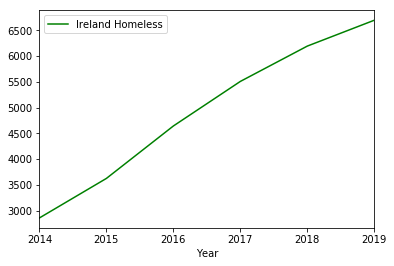

In [6]:
# Generate time series plot of homelessness in Ireland 2014-2019
ax = plt.gca()
homeless_df.plot(kind='line',x='Year',y='Ireland Homeless', color = 'green', ax=ax)
plt.show()

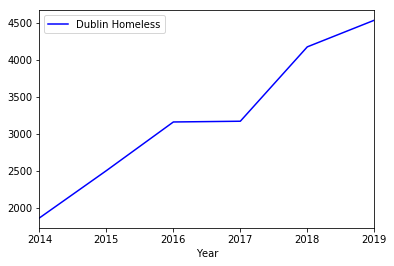

In [7]:
# Generate time series plot of homelessness in Dublin 2014-2019
ax = plt.gca()
homeless_df.plot(kind='line',x='Year',y='Dublin Homeless', color = 'blue', ax=ax)
plt.show()

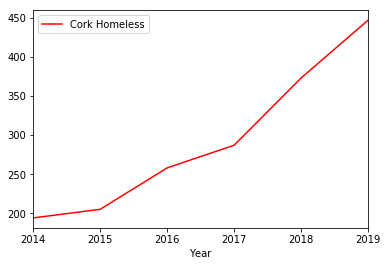

In [8]:
#Generate time series plot of homelessness in Cork 2014-2019
ax = plt.gca()
homeless_df.plot(kind='line',x='Year',y='Cork Homeless', color='red', ax=ax)
plt.show()

As can be seen from the homelessness trends, the number of homeless persons has more than doubled in Ireland, Dublin and Cork in the period of 2014-2019

In [9]:
# Import & clean Ireland new dwelling completions 2000-2012 from CSO website
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
newDwlList_df = pd.read_excel('https://www.cso.ie/en/media/csoie/releasespublications/documents/ep/measuringirelandsprogress/2012/economy/P-MIP2012TBL2.19.xlsx', skiprows=2)

# Eliminate rows with unnecessary data
newDwlList_df = newDwlList_df.drop([0, 1, 2, 3, 4, 5, 19], axis=0).reset_index(drop=True)

# Convert number of dwellings to an integer
newDwlList_df['Number of dwellings'] = newDwlList_df['Number of dwellings'].astype(int)
newDwlList_df.head(30)

Year  Number of dwellings
0   2000                49812
1   2001                52602
2   2002                57695
3   2003                68819
4   2004                76954
5   2005                85957
6   2006                88419
7   2007                78027
8   2008                51724
9   2009                26420
10  2010                14602
11  2011                10480
12  2012                 8488

In [10]:
# generate ireland new dwelling completions data lists and dataframe for years 2013-2019
# This datframe must be created manually as dataset is in pdf format (not a big issue as datset is small)
# First generate lists to contain data
dyears = ['2013', '2014', '2015', '2016', '2017', '2018', '2019']
irl_Dwl = [4575, 5518, 7219, 9892, 14368, 17995, 19685]

# Create dataframe of new dwelling completions
newDwl_df = pd.DataFrame(list(zip(dyears, irl_Dwl)),
                          columns = ('Year', 'Number of dwellings'))
newDwl_df.head(7)

Year  Number of dwellings
0  2013                 4575
1  2014                 5518
2  2015                 7219
3  2016                 9892
4  2017                14368
5  2018                17995
6  2019                19685

In [11]:
# Add 2013-2019 dataset to 2000-2012 datset using append function
newDwlFinal_df = newDwlList_df.append(newDwl_df, ignore_index = True)
newDwlFinal_df.head(20)

Year  Number of dwellings
0   2000                49812
1   2001                52602
2   2002                57695
3   2003                68819
4   2004                76954
5   2005                85957
6   2006                88419
7   2007                78027
8   2008                51724
9   2009                26420
10  2010                14602
11  2011                10480
12  2012                 8488
13  2013                 4575
14  2014                 5518
15  2015                 7219
16  2016                 9892
17  2017                14368
18  2018                17995
19  2019                19685

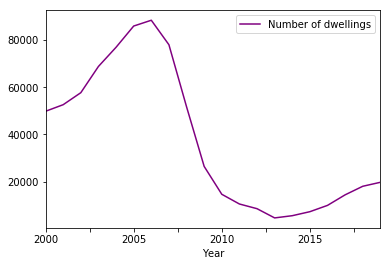

In [12]:
#Generate time series plot of new dwelling completions in Ireland 2011-2019
ax = plt.gca()
newDwlFinal_df.plot(kind='line',x='Year',y='Number of dwellings', color='purple', ax=ax)
plt.show()

As can be seen from the data and time series plot, the number of new dwelling completions hit a low of 4,575 in 2013 (about 4-5 years after the property crash of 2008/2009).
Since then the number of new dwelling completions has accelerated rapidly reaching 19,685 in 2019.
Despite this, the number of new dwelling completions is not keeping up with demand as demonstarted by the increasing numbers of homeless.

## Download & Pre-Process Dublin Airbnb Listings

In [13]:
# Download Dublin Airbnb listings csv file
dubList_url='http://data.insideairbnb.com/ireland/leinster/dublin/2019-11-26/visualisations/listings.csv'
dubList_df = pd.read_csv(dubList_url) 
dubList_df.describe()
dubList_df.head(10)

id                                          name  host_id host_name  \
0   44077           cosy comfortable Irish cottage twin   193005    Teresa   
1   85148              Habitación en Dublín Double room   466111       Don   
2   85156  Cosy Comfortable Irish Cottage  1 Double Bed   193005    Teresa   
3  121030           Comfy double room in central area 1   608225     Norah   
4  159889                          Friendly Single Room   766611  Margaret   
5  162809            5.5 miles south of Dublin City :^)   777681    Robbie   
6  165828                Pádraig Pearse apt. Kilmainham   790601   Grainne   
7  165829               The "Michael Collins" apartment   790601   Grainne   
8  178860           Georgian House in Heart of City Ctr   856312  Danielle   
9  181823                   comfy room near beach/town2   608225     Norah   

   neighbourhood_group          neighbourhood  latitude  longitude  \
0                  NaN  Dn Laoghaire-Rathdown  53.28995   -6.25813   
1                  NaN           South Dublin  53.30110   -6.31992   
2                  NaN  Dn Laoghaire-Rathdown  53.29178   -6.25618   
3                  NaN            Dublin City  53.33648   -6.22075   
4                  NaN            Dublin City  53.38988   -6.23620   
5                  NaN  Dn Laoghaire-Rathdown  53.28445   -6.19094   
6                  NaN            Dublin City  53.33630   -6.32439   
7                  NaN            Dublin City  53.33811   -6.32259   
8                  NaN            Dublin City  53.33282   -6.26821   
9                  NaN            Dublin City  53.33650   -6.22066   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room     50               3                219  2019-11-25   
1     Private room     30               1                  1  2019-05-11   
2     Private room     50               3                170  2019-11-11   
3     Private room     55               2                110  2019-03-19   
4     Private room     29               1                304  2019-11-24   
5     Private room     55               1                274  2019-11-10   
6  Entire home/apt    147               3                 43  2019-10-22   
7  Entire home/apt    135               3                 51  2019-06-29   
8     Private room     56               2                306  2019-11-22   
9     Private room     75               2                110  2019-11-21   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               2.07                               3               240  
1               0.15                               1                24  
2               1.64                               3               223  
3               1.07                               3                84  
4               3.25                               3               275  
5               5.01                               2                96  
6               0.44                               5               280  
7               0.53                               5               267  
8               3.48                               2               166  
9               1.11                               3                 0

There are two types of property available (Private Room and Entire home/apt)
As this study is particularly interested in the impact of Airbnb on available homes to rent,
the number of Entire home/apt is more relevant than the number of Private room.
It was decided to remove the rows with Private Room as the property type.

In [14]:
# Remove rows where the property type is Private Room
dubList2_df = dubList_df[dubList_df.room_type != 'Private room'].reset_index(drop=True)
dubList2_df.head(10)

id                                               name  host_id  \
0  165828                     Pádraig Pearse apt. Kilmainham   790601   
1  165829                    The "Michael Collins" apartment   790601   
2  200979                       "The Lodge, Dalkey Avenue ."   982970   
3  237465  Cozy warm Annexe 10 mins to airport. total pri...  1245198   
4  275425  Luxury family home with all amenities (6 persons)  1357428   
5  292757  Old World Converted Stableyard with Swimming Pool  1515549   
6  302554        Peaceful retreat for 5 - excellent location  1557844   
7  302634    Studio sleeps 2 city ctr 10 mins - Molly Malone  1557844   
8  365854                     Boutique Cosy Centre Apartment  1847391   
9  374792                'Grace Gifford' cottage, Kilmainham   790601   

        host_name  neighbourhood_group          neighbourhood  latitude  \
0         Grainne                  NaN            Dublin City  53.33630   
1         Grainne                  NaN            Dublin City  53.33811   
2            Paul                  NaN  Dn Laoghaire-Rathdown  53.27420   
3          Amanda                  NaN            Dublin City  53.39615   
4  Emma And Chris                  NaN            Dublin City  53.32670   
5           Sarah                  NaN                 Fingal  53.36958   
6  Liam And Fiona                  NaN            Dublin City  53.35628   
7  Liam And Fiona                  NaN            Dublin City  53.35561   
8           Diane                  NaN            Dublin City  53.35305   
9         Grainne                  NaN            Dublin City  53.33680   

   longitude        room_type  price  minimum_nights  number_of_reviews  \
0   -6.32439  Entire home/apt    147               3                 43   
1   -6.32259  Entire home/apt    135               3                 51   
2   -6.10917  Entire home/apt    220               2                141   
3   -6.17456  Entire home/apt     55               2                257   
4   -6.20921  Entire home/apt    248               3                  7   
5   -6.34959  Entire home/apt    120               1                317   
6   -6.28981  Entire home/apt    180               2                 56   
7   -6.29149  Entire home/apt    100               2                 80   
8   -6.25708  Entire home/apt     85               2                181   
9   -6.32410  Entire home/apt    135               3                 28   

  last_review  reviews_per_month  calculated_host_listings_count  \
0  2019-10-22               0.44                               5   
1  2019-06-29               0.53                               5   
2  2019-11-24               1.53                               1   
3  2019-11-17               2.66                               3   
4  2019-07-07               0.07                               1   
5  2019-11-17               3.60                               1   
6  2019-09-25               0.60                               8   
7  2019-09-30               0.85                               8   
8  2019-11-10               1.93                               1   
9  2019-06-30               0.31                               5   

   availability_365  
0               280  
1               267  
2               232  
3               225  
4                33  
5               144  
6               325  
7               277  
8               176  
9               277

In [15]:
# Remove rows where the availability_365 is zero
dubList3_df = dubList2_df[dubList2_df.availability_365 != 0].reset_index(drop=True)
dubList3_df.describe()
dubList3_df.head(10)

id                                               name  host_id  \
0  165828                     Pádraig Pearse apt. Kilmainham   790601   
1  165829                    The "Michael Collins" apartment   790601   
2  200979                       "The Lodge, Dalkey Avenue ."   982970   
3  237465  Cozy warm Annexe 10 mins to airport. total pri...  1245198   
4  275425  Luxury family home with all amenities (6 persons)  1357428   
5  292757  Old World Converted Stableyard with Swimming Pool  1515549   
6  302554        Peaceful retreat for 5 - excellent location  1557844   
7  302634    Studio sleeps 2 city ctr 10 mins - Molly Malone  1557844   
8  365854                     Boutique Cosy Centre Apartment  1847391   
9  374792                'Grace Gifford' cottage, Kilmainham   790601   

        host_name  neighbourhood_group          neighbourhood  latitude  \
0         Grainne                  NaN            Dublin City  53.33630   
1         Grainne                  NaN            Dublin City  53.33811   
2            Paul                  NaN  Dn Laoghaire-Rathdown  53.27420   
3          Amanda                  NaN            Dublin City  53.39615   
4  Emma And Chris                  NaN            Dublin City  53.32670   
5           Sarah                  NaN                 Fingal  53.36958   
6  Liam And Fiona                  NaN            Dublin City  53.35628   
7  Liam And Fiona                  NaN            Dublin City  53.35561   
8           Diane                  NaN            Dublin City  53.35305   
9         Grainne                  NaN            Dublin City  53.33680   

   longitude        room_type  price  minimum_nights  number_of_reviews  \
0   -6.32439  Entire home/apt    147               3                 43   
1   -6.32259  Entire home/apt    135               3                 51   
2   -6.10917  Entire home/apt    220               2                141   
3   -6.17456  Entire home/apt     55               2                257   
4   -6.20921  Entire home/apt    248               3                  7   
5   -6.34959  Entire home/apt    120               1                317   
6   -6.28981  Entire home/apt    180               2                 56   
7   -6.29149  Entire home/apt    100               2                 80   
8   -6.25708  Entire home/apt     85               2                181   
9   -6.32410  Entire home/apt    135               3                 28   

  last_review  reviews_per_month  calculated_host_listings_count  \
0  2019-10-22               0.44                               5   
1  2019-06-29               0.53                               5   
2  2019-11-24               1.53                               1   
3  2019-11-17               2.66                               3   
4  2019-07-07               0.07                               1   
5  2019-11-17               3.60                               1   
6  2019-09-25               0.60                               8   
7  2019-09-30               0.85                               8   
8  2019-11-10               1.93                               1   
9  2019-06-30               0.31                               5   

   availability_365  
0               280  
1               267  
2               232  
3               225  
4                33  
5               144  
6               325  
7               277  
8               176  
9               277

Some of the colums are less relevant for the study.
It was decided to clean up the dataframe by removing the following columns:
host_name
neighbourhood_group
minimum_nights
number_of_reviews
last_review
reviews_per_month

In [16]:
dubListFinal_df = dubList3_df.drop(['host_name', 'neighbourhood_group', 'minimum_nights', 'number_of_reviews', 'reviews_per_month','last_review', 'calculated_host_listings_count'], axis=1)
dubListFinal_df.head(10)                                    

id                                               name  host_id  \
0  165828                     Pádraig Pearse apt. Kilmainham   790601   
1  165829                    The "Michael Collins" apartment   790601   
2  200979                       "The Lodge, Dalkey Avenue ."   982970   
3  237465  Cozy warm Annexe 10 mins to airport. total pri...  1245198   
4  275425  Luxury family home with all amenities (6 persons)  1357428   
5  292757  Old World Converted Stableyard with Swimming Pool  1515549   
6  302554        Peaceful retreat for 5 - excellent location  1557844   
7  302634    Studio sleeps 2 city ctr 10 mins - Molly Malone  1557844   
8  365854                     Boutique Cosy Centre Apartment  1847391   
9  374792                'Grace Gifford' cottage, Kilmainham   790601   

           neighbourhood  latitude  longitude        room_type  price  \
0            Dublin City  53.33630   -6.32439  Entire home/apt    147   
1            Dublin City  53.33811   -6.32259  Entire home/apt    135   
2  Dn Laoghaire-Rathdown  53.27420   -6.10917  Entire home/apt    220   
3            Dublin City  53.39615   -6.17456  Entire home/apt     55   
4            Dublin City  53.32670   -6.20921  Entire home/apt    248   
5                 Fingal  53.36958   -6.34959  Entire home/apt    120   
6            Dublin City  53.35628   -6.28981  Entire home/apt    180   
7            Dublin City  53.35561   -6.29149  Entire home/apt    100   
8            Dublin City  53.35305   -6.25708  Entire home/apt     85   
9            Dublin City  53.33680   -6.32410  Entire home/apt    135   

   availability_365  
0               280  
1               267  
2               232  
3               225  
4                33  
5               144  
6               325  
7               277  
8               176  
9               277

In [17]:
# Add a new column called max_annual_earnings to dataframe to multiply price by availability_365
dubListFinal_df['max_annual_earnings'] = dubListFinal_df['price']*dubListFinal_df['availability_365']
dubListFinal_df.head(10)

id                                               name  host_id  \
0  165828                     Pádraig Pearse apt. Kilmainham   790601   
1  165829                    The "Michael Collins" apartment   790601   
2  200979                       "The Lodge, Dalkey Avenue ."   982970   
3  237465  Cozy warm Annexe 10 mins to airport. total pri...  1245198   
4  275425  Luxury family home with all amenities (6 persons)  1357428   
5  292757  Old World Converted Stableyard with Swimming Pool  1515549   
6  302554        Peaceful retreat for 5 - excellent location  1557844   
7  302634    Studio sleeps 2 city ctr 10 mins - Molly Malone  1557844   
8  365854                     Boutique Cosy Centre Apartment  1847391   
9  374792                'Grace Gifford' cottage, Kilmainham   790601   

           neighbourhood  latitude  longitude        room_type  price  \
0            Dublin City  53.33630   -6.32439  Entire home/apt    147   
1            Dublin City  53.33811   -6.32259  Entire home/apt    135   
2  Dn Laoghaire-Rathdown  53.27420   -6.10917  Entire home/apt    220   
3            Dublin City  53.39615   -6.17456  Entire home/apt     55   
4            Dublin City  53.32670   -6.20921  Entire home/apt    248   
5                 Fingal  53.36958   -6.34959  Entire home/apt    120   
6            Dublin City  53.35628   -6.28981  Entire home/apt    180   
7            Dublin City  53.35561   -6.29149  Entire home/apt    100   
8            Dublin City  53.35305   -6.25708  Entire home/apt     85   
9            Dublin City  53.33680   -6.32410  Entire home/apt    135   

   availability_365  max_annual_earnings  
0               280                41160  
1               267                36045  
2               232                51040  
3               225                12375  
4                33                 8184  
5               144                17280  
6               325                58500  
7               277                27700  
8               176                14960  
9               277                37395

In [18]:
# Inspect the Dublin Airbnb Listings dataset
dubListFinal_df.describe()

id       host_id     latitude    longitude        price  \
count  2.912000e+03  2.912000e+03  2912.000000  2912.000000  2912.000000   
mean   2.445844e+07  1.003200e+08    53.344722    -6.252321   189.008585   
std    1.097213e+07  9.012047e+07     0.040621     0.052371   282.576011   
min    1.658280e+05  1.922100e+05    53.211130    -6.519370    10.000000   
25%    1.637653e+07  2.414125e+07    53.331815    -6.274235    98.000000   
50%    2.540806e+07  6.857736e+07    53.343910    -6.260060   140.000000   
75%    3.429921e+07  1.624024e+08    53.353450    -6.238465   200.000000   
max    4.037631e+07  3.120656e+08    53.606000    -6.025940  8956.000000   

       availability_365  max_annual_earnings  
count       2912.000000         2.912000e+03  
mean         136.196429         2.832478e+04  
std          115.914312         4.779030e+04  
min            1.000000         4.000000e+01  
25%           37.000000         4.274250e+03  
50%           91.000000         1.391000e+04  
75%          231.250000         3.240000e+04  
max          365.000000         1.128400e+06

In [19]:
print(dubListFinal_df.shape)

(2912, 10)


There are a total of 2,912 relevant Airbnb listings in Dublin which are not single rooms.
As the number of homeless in Dublin is 4,534 persons, even if all of these properties were freed up
for long term rental, it is unlikley that these would resolve the homelessness issue.
However if we assume that some of the people listed as homeless are family groups, freeing up some of these
properties for homeless family long term rental could help alleviate the homelessness issue.

In [20]:
# Check the number of Dublin Airbnb listings that exceed the 90 day cap for rent pressure zones set by the new Irish government legislation
dubList90_df = dubListFinal_df[dubListFinal_df['availability_365']>90]
print(dubList90_df.shape)

(1462, 10)


This is interesting as it indicates that 1,462 of the 2,912 listings (approx. 50%) exceed the 90 day cap set by the new government legislation.
This may be due to the law being new and not being fully understood by landlords and not yet being strongly enforced by local government.

In [23]:
# Check the number of Dublin Airbnb listings that are available more than half the year (180 days)
dubList180_df = dubListFinal_df[dubListFinal_df['availability_365']>180]
print(dubList180_df.shape)

(867, 10)


In [24]:
# Check the number of Dublin Airbnb listings that are availble all year round(365 days)
dubList180_df = dubListFinal_df[dubListFinal_df['availability_365']==365]
print(dubList180_df.shape)

(53, 10)


## Download & Pre-Process Cork Airbnb Listings

Because Cork is a much smaller city than Dublin, and very small by international standards there is no separate Airbnb listings dataset available for Cork.
It will be necessary to download the Ireland dataset and extract the Cork city data from it.

In [25]:
# Download Ireland Airbnb listings csv file
ireList_url='http://data.insideairbnb.com/ireland/2019-11-23/visualisations/listings.csv'
ireList_df = pd.read_csv(ireList_url) 
ireList_df.describe()
ireList_df.head(10)

id                                               name    host_id  \
0  20436982  Close to city centre, situated in charming vil...   14893205   
1  39364220                      The perfect Dublin apartment!  302362865   
2  16263733                Double bedroom next to Phoenix park   42059994   
3  40138082              Bright home in a quiet neighbourhood.  172538850   
4   3581384  CONTEMPORARY 3 BEDROOM TOWNHOUSE CENTRAL, SLEE...   17981524   
5  21167665                       Doble bedroom in walkinstown   24183424   
6  15464515   Iveagh Cottage, 3 bedroom warm house with garden   97033971   
7  37226483   A modern 3 bed home with easy access to the city   20214456   
8  13620699  1 bedroom Apt. with full facilities. Close to ...   78889552   
9  13759419  3 Bed Ensuited Space Free Parking & City Tram ...   37019750   

    host_name  neighbourhood_group               neighbourhood  latitude  \
0       Laura  Dublin City Council  Ballyfermot-Drimnagh LEA-5  53.34940   
1  James Alex  Dublin City Council  Ballyfermot-Drimnagh LEA-5  53.34772   
2    Nastasia  Dublin City Council  Ballyfermot-Drimnagh LEA-5  53.34239   
3       Maeve  Dublin City Council  Ballyfermot-Drimnagh LEA-5  53.32258   
4   Christina  Dublin City Council  Ballyfermot-Drimnagh LEA-5  53.32697   
5      Marcos  Dublin City Council  Ballyfermot-Drimnagh LEA-5  53.31961   
6      Celine  Dublin City Council  Ballyfermot-Drimnagh LEA-5  53.32899   
7        Mark  Dublin City Council  Ballyfermot-Drimnagh LEA-5  53.31804   
8        Mary  Dublin City Council  Ballyfermot-Drimnagh LEA-5  53.34563   
9       Sammy  Dublin City Council  Ballyfermot-Drimnagh LEA-5  53.33509   

   longitude        room_type  price  minimum_nights  number_of_reviews  \
0   -6.34664  Entire home/apt     90               1                 11   
1   -6.34647  Entire home/apt    110               3                  1   
2   -6.32926     Private room     39               1                  0   
3   -6.32710  Entire home/apt    120               2                  0   
4   -6.31395  Entire home/apt    175              15                 20   
5   -6.32238     Private room     40               3                  1   
6   -6.31619  Entire home/apt    167               2                  8   
7   -6.32237  Entire home/apt    150               2                  2   
8   -6.34237  Entire home/apt     50               1                  3   
9   -6.32970  Entire home/apt     80               2                 18   

   number_of_reviews_ltm last_review  calculated_host_listings_count  \
0                      0  2018-09-18                               1   
1                      1  2019-11-17                               1   
2                      0         NaN                               2   
3                      0         NaN                               1   
4                      9  2019-08-18                               5   
5                      0  2017-10-14                               2   
6                      0  2018-03-08                               1   
7                      2  2019-11-02                               2   
8                      0  2017-09-03                               1   
9                     14  2019-11-17                               1   

   availability_365  
0                 0  
1                20  
2                 0  
3                18  
4                 0  
5                 0  
6               365  
7                 0  
8                 0  
9               108

In [26]:
# Extract Cork city council entries from the dataset
ireList2_df = ireList_df.loc[ireList_df['neighbourhood_group'].isin(['Cork City Council'])].reset_index(drop=True)
ireList2_df.describe()
ireList2_df.head(10)

id                                               name    host_id  \
0  39663754              Matress and sofa for budget traveller   81353277   
1   9548704                       modern open plan 2 bed house   49447447   
2  13344373                House in Cork City centre - 3 rooms   58764063   
3  17735027  Modern & quiet double bed room in Cork City Ce...   33304958   
4  40010839                     Cork City Centre Accommodation   39466924   
5  20578464               Modern bedroom with private bathroom   13108197   
6  33509612          Home from home near Cork City and Airport  252273604   
7  27196730  City centre   1  bedroom apartment own door un...  107437226   
8   3088179  Private Double Room Apartment in the heart of ...     193834   
9  32834364                   3 Altona college road, cork city   56311866   

  host_name neighbourhood_group                  neighbourhood  latitude  \
0        卓霖   Cork City Council  Cork City South Central LEA-6  51.89433   
1     Fiona   Cork City Council  Cork City South Central LEA-6  51.89126   
2     David   Cork City Council  Cork City South Central LEA-6  51.88995   
3   Justine   Cork City Council  Cork City South Central LEA-6  51.89922   
4    Sharon   Cork City Council  Cork City South Central LEA-6  51.89304   
5  Jennifer   Cork City Council  Cork City South Central LEA-6  51.89611   
6       Dee   Cork City Council  Cork City South Central LEA-6  51.86900   
7   Anthony   Cork City Council  Cork City South Central LEA-6  51.89633   
8     Maria   Cork City Council  Cork City South Central LEA-6  51.89269   
9     Conor   Cork City Council  Cork City South Central LEA-6  51.89221   

   longitude        room_type  price  minimum_nights  number_of_reviews  \
0   -8.49582     Private room     25               1                  1   
1   -8.46324  Entire home/apt    125               3                 88   
2   -8.47027  Entire home/apt    125               2                 11   
3   -8.47273     Private room     50               1                 16   
4   -8.48385     Private room     90              30                  0   
5   -8.46584     Private room     60               3                 73   
6   -8.46627     Private room     45               2                 16   
7   -8.48618  Entire home/apt     85               1                121   
8   -8.47284  Entire home/apt     49               2                260   
9   -8.48773  Entire home/apt    160               3                  4   

   number_of_reviews_ltm last_review  calculated_host_listings_count  \
0                      1  2019-11-10                               2   
1                     13  2019-10-20                               1   
2                      2  2019-07-07                               1   
3                     16  2019-09-16                               1   
4                      0         NaN                               2   
5                     26  2019-08-01                               1   
6                     16  2019-10-03                               2   
7                     88  2019-11-01                               6   
8                     62  2019-11-24                               1   
9                      4  2019-08-11                               3   

   availability_365  
0                 0  
1               342  
2               168  
3                 0  
4               113  
5                 0  
6                 1  
7               160  
8               184  
9                 0

In [27]:
# Remove rows where the property type is Private Room
ireList3_df = ireList2_df[ireList2_df.room_type != 'Private room'].reset_index(drop=True)
ireList3_df.describe()
ireList3_df.head(10)

id                                               name    host_id  \
0   9548704                       modern open plan 2 bed house   49447447   
1  13344373                House in Cork City centre - 3 rooms   58764063   
2  27196730  City centre   1  bedroom apartment own door un...  107437226   
3   3088179  Private Double Room Apartment in the heart of ...     193834   
4  32834364                   3 Altona college road, cork city   56311866   
5  25505651                              City Centre Apartment  192477332   
6  24804603          One bedroom flat in listed Georgian house     907742   
7  38741027        Newly Built 5 Bedroom City Center Apartment  296266292   
8  15388361                            9 Magazine rd cork city   56311866   
9  36666968                     Gems Place - Modern Apartment.   42822025   

   host_name neighbourhood_group                  neighbourhood  latitude  \
0      Fiona   Cork City Council  Cork City South Central LEA-6  51.89126   
1      David   Cork City Council  Cork City South Central LEA-6  51.88995   
2    Anthony   Cork City Council  Cork City South Central LEA-6  51.89633   
3      Maria   Cork City Council  Cork City South Central LEA-6  51.89269   
4      Conor   Cork City Council  Cork City South Central LEA-6  51.89221   
5       Alma   Cork City Council  Cork City South Central LEA-6  51.89704   
6       John   Cork City Council  Cork City South Central LEA-6  51.88932   
7  Lee Point   Cork City Council  Cork City South Central LEA-6  51.89623   
8      Conor   Cork City Council  Cork City South Central LEA-6  51.88914   
9        Gem   Cork City Council  Cork City South Central LEA-6  51.86630   

   longitude        room_type  price  minimum_nights  number_of_reviews  \
0   -8.46324  Entire home/apt    125               3                 88   
1   -8.47027  Entire home/apt    125               2                 11   
2   -8.48618  Entire home/apt     85               1                121   
3   -8.47284  Entire home/apt     49               2                260   
4   -8.48773  Entire home/apt    160               3                  4   
5   -8.47654  Entire home/apt     91               2                 54   
6   -8.46825  Entire home/apt     52              15                101   
7   -8.47748  Entire home/apt    400               1                  0   
8   -8.50054  Entire home/apt    175               2                 23   
9   -8.46725  Entire home/apt     76               2                 43   

   number_of_reviews_ltm last_review  calculated_host_listings_count  \
0                     13  2019-10-20                               1   
1                      2  2019-07-07                               1   
2                     88  2019-11-01                               6   
3                     62  2019-11-24                               1   
4                      4  2019-08-11                               3   
5                     18  2019-03-13                               1   
6                     55  2019-09-29                               4   
7                      0         NaN                               3   
8                      7  2019-08-17                               3   
9                     43  2019-11-23                               4   

   availability_365  
0               342  
1               168  
2               160  
3               184  
4                 0  
5                 0  
6                90  
7                90  
8                37  
9               287

In [28]:
# Remove rows where the availability_365 is zero
ireList4_df = ireList3_df[ireList3_df.availability_365 != 0].reset_index(drop=True)
ireList4_df.describe()
ireList4_df.head(10)

id                                               name    host_id  \
0   9548704                       modern open plan 2 bed house   49447447   
1  13344373                House in Cork City centre - 3 rooms   58764063   
2  27196730  City centre   1  bedroom apartment own door un...  107437226   
3   3088179  Private Double Room Apartment in the heart of ...     193834   
4  24804603          One bedroom flat in listed Georgian house     907742   
5  38741027        Newly Built 5 Bedroom City Center Apartment  296266292   
6  15388361                            9 Magazine rd cork city   56311866   
7  36666968                     Gems Place - Modern Apartment.   42822025   
8  17311815    Cork City Centre Bright & Airy 2 Bedroom Duplex  116823097   
9  19499792      Self catering 'Luxury' 1, 2 or3 bedroom Suite  136913954   

   host_name neighbourhood_group                  neighbourhood  latitude  \
0      Fiona   Cork City Council  Cork City South Central LEA-6  51.89126   
1      David   Cork City Council  Cork City South Central LEA-6  51.88995   
2    Anthony   Cork City Council  Cork City South Central LEA-6  51.89633   
3      Maria   Cork City Council  Cork City South Central LEA-6  51.89269   
4       John   Cork City Council  Cork City South Central LEA-6  51.88932   
5  Lee Point   Cork City Council  Cork City South Central LEA-6  51.89623   
6      Conor   Cork City Council  Cork City South Central LEA-6  51.88914   
7        Gem   Cork City Council  Cork City South Central LEA-6  51.86630   
8      Susan   Cork City Council  Cork City South Central LEA-6  51.89624   
9      Brian   Cork City Council  Cork City South Central LEA-6  51.89426   

   longitude        room_type  price  minimum_nights  number_of_reviews  \
0   -8.46324  Entire home/apt    125               3                 88   
1   -8.47027  Entire home/apt    125               2                 11   
2   -8.48618  Entire home/apt     85               1                121   
3   -8.47284  Entire home/apt     49               2                260   
4   -8.46825  Entire home/apt     52              15                101   
5   -8.47748  Entire home/apt    400               1                  0   
6   -8.50054  Entire home/apt    175               2                 23   
7   -8.46725  Entire home/apt     76               2                 43   
8   -8.46968  Entire home/apt    120               2                295   
9   -8.49226  Entire home/apt    188               1                123   

   number_of_reviews_ltm last_review  calculated_host_listings_count  \
0                     13  2019-10-20                               1   
1                      2  2019-07-07                               1   
2                     88  2019-11-01                               6   
3                     62  2019-11-24                               1   
4                     55  2019-09-29                               4   
5                      0         NaN                               3   
6                      7  2019-08-17                               3   
7                     43  2019-11-23                               4   
8                    106  2019-11-24                               1   
9                     42  2019-11-16                               3   

   availability_365  
0               342  
1               168  
2               160  
3               184  
4                90  
5                90  
6                37  
7               287  
8                60  
9               355

In [29]:
# Remove the uneccessary LEA-6 & LEA-7 suffix on the neighbourhood names
ireList4_df['neighbourhood'] = ireList4_df['neighbourhood'].map(lambda x: x.rstrip('LEA-6'))
ireList4_df['neighbourhood'] = ireList4_df['neighbourhood'].map(lambda x: x.rstrip('LEA-7'))
ireList4_df.head()

id                                               name    host_id  \
0   9548704                       modern open plan 2 bed house   49447447   
1  13344373                House in Cork City centre - 3 rooms   58764063   
2  27196730  City centre   1  bedroom apartment own door un...  107437226   
3   3088179  Private Double Room Apartment in the heart of ...     193834   
4  24804603          One bedroom flat in listed Georgian house     907742   

  host_name neighbourhood_group             neighbourhood  latitude  \
0     Fiona   Cork City Council  Cork City South Central   51.89126   
1     David   Cork City Council  Cork City South Central   51.88995   
2   Anthony   Cork City Council  Cork City South Central   51.89633   
3     Maria   Cork City Council  Cork City South Central   51.89269   
4      John   Cork City Council  Cork City South Central   51.88932   

   longitude        room_type  price  minimum_nights  number_of_reviews  \
0   -8.46324  Entire home/apt    125               3                 88   
1   -8.47027  Entire home/apt    125               2                 11   
2   -8.48618  Entire home/apt     85               1                121   
3   -8.47284  Entire home/apt     49               2                260   
4   -8.46825  Entire home/apt     52              15                101   

   number_of_reviews_ltm last_review  calculated_host_listings_count  \
0                     13  2019-10-20                               1   
1                      2  2019-07-07                               1   
2                     88  2019-11-01                               6   
3                     62  2019-11-24                               1   
4                     55  2019-09-29                               4   

   availability_365  
0               342  
1               168  
2               160  
3               184  
4                90

In [30]:
# Remove unnecessary columns to generate final Cork listings dataframe with the same format as the final Dublin listings dataframe
corListFinal_df = ireList4_df.drop(['host_name', 'neighbourhood_group', 'minimum_nights', 'number_of_reviews', 'number_of_reviews', 'number_of_reviews_ltm', 'last_review', 'calculated_host_listings_count',], axis=1).reset_index(drop=True)
corListFinal_df.head(10)

id                                               name    host_id  \
0   9548704                       modern open plan 2 bed house   49447447   
1  13344373                House in Cork City centre - 3 rooms   58764063   
2  27196730  City centre   1  bedroom apartment own door un...  107437226   
3   3088179  Private Double Room Apartment in the heart of ...     193834   
4  24804603          One bedroom flat in listed Georgian house     907742   
5  38741027        Newly Built 5 Bedroom City Center Apartment  296266292   
6  15388361                            9 Magazine rd cork city   56311866   
7  36666968                     Gems Place - Modern Apartment.   42822025   
8  17311815    Cork City Centre Bright & Airy 2 Bedroom Duplex  116823097   
9  19499792      Self catering 'Luxury' 1, 2 or3 bedroom Suite  136913954   

              neighbourhood  latitude  longitude        room_type  price  \
0  Cork City South Central   51.89126   -8.46324  Entire home/apt    125   
1  Cork City South Central   51.88995   -8.47027  Entire home/apt    125   
2  Cork City South Central   51.89633   -8.48618  Entire home/apt     85   
3  Cork City South Central   51.89269   -8.47284  Entire home/apt     49   
4  Cork City South Central   51.88932   -8.46825  Entire home/apt     52   
5  Cork City South Central   51.89623   -8.47748  Entire home/apt    400   
6  Cork City South Central   51.88914   -8.50054  Entire home/apt    175   
7  Cork City South Central   51.86630   -8.46725  Entire home/apt     76   
8  Cork City South Central   51.89624   -8.46968  Entire home/apt    120   
9  Cork City South Central   51.89426   -8.49226  Entire home/apt    188   

   availability_365  
0               342  
1               168  
2               160  
3               184  
4                90  
5                90  
6                37  
7               287  
8                60  
9               355

In [31]:
# Add a new column called max_annual_earnings to dataframe to multiply price by availability_365
corListFinal_df['max_annual_earnings'] = corListFinal_df['price']*corListFinal_df['availability_365']
corListFinal_df.head(10)

id                                               name    host_id  \
0   9548704                       modern open plan 2 bed house   49447447   
1  13344373                House in Cork City centre - 3 rooms   58764063   
2  27196730  City centre   1  bedroom apartment own door un...  107437226   
3   3088179  Private Double Room Apartment in the heart of ...     193834   
4  24804603          One bedroom flat in listed Georgian house     907742   
5  38741027        Newly Built 5 Bedroom City Center Apartment  296266292   
6  15388361                            9 Magazine rd cork city   56311866   
7  36666968                     Gems Place - Modern Apartment.   42822025   
8  17311815    Cork City Centre Bright & Airy 2 Bedroom Duplex  116823097   
9  19499792      Self catering 'Luxury' 1, 2 or3 bedroom Suite  136913954   

              neighbourhood  latitude  longitude        room_type  price  \
0  Cork City South Central   51.89126   -8.46324  Entire home/apt    125   
1  Cork City South Central   51.88995   -8.47027  Entire home/apt    125   
2  Cork City South Central   51.89633   -8.48618  Entire home/apt     85   
3  Cork City South Central   51.89269   -8.47284  Entire home/apt     49   
4  Cork City South Central   51.88932   -8.46825  Entire home/apt     52   
5  Cork City South Central   51.89623   -8.47748  Entire home/apt    400   
6  Cork City South Central   51.88914   -8.50054  Entire home/apt    175   
7  Cork City South Central   51.86630   -8.46725  Entire home/apt     76   
8  Cork City South Central   51.89624   -8.46968  Entire home/apt    120   
9  Cork City South Central   51.89426   -8.49226  Entire home/apt    188   

   availability_365  max_annual_earnings  
0               342                42750  
1               168                21000  
2               160                13600  
3               184                 9016  
4                90                 4680  
5                90                36000  
6                37                 6475  
7               287                21812  
8                60                 7200  
9               355                66740

In [32]:
# Inspect the Cork Airbnb Listings dataset
corListFinal_df.describe()

id       host_id    latitude   longitude       price  \
count  1.780000e+02  1.780000e+02  178.000000  178.000000  178.000000   
mean   2.592194e+07  9.845497e+07   51.896259   -8.468609  120.977528   
std    9.973798e+06  8.846174e+07    0.017187    0.036348   64.022238   
min    3.493120e+05  1.938340e+05   51.849730   -8.599050   30.000000   
25%    1.864586e+07  2.839399e+07   51.888747   -8.479360   80.000000   
50%    2.668437e+07  6.555958e+07   51.897095   -8.470430  101.500000   
75%    3.437753e+07  1.578767e+08   51.903295   -8.452690  145.000000   
max    4.027582e+07  3.030647e+08   51.950080   -8.379510  400.000000   

       availability_365  max_annual_earnings  
count        178.000000           178.000000  
mean         174.511236         22321.994382  
std          116.717063         22108.631742  
min            1.000000            70.000000  
25%           71.000000          6186.250000  
50%          166.000000         16000.000000  
75%          300.000000         30952.500000  
max          358.000000        122150.000000

In [33]:
print(corListFinal_df.shape)

(178, 10)


There are a total of 178 relevant Airbnb listings in Cork which are not single rooms.
As the number of homeless in Cork is 447 persons, even if all of these properties were freed up
for long term rental, it would resolve the homelessness issue.
However if we assume that some of the people listed as homeless are family groups, freeing up some of these
properties for homeless family long term rental could help alleviate the homelessness issue.

In [34]:
# Check the number of Cork Airbnb listings that exceed the 90 day cap for rent pressure zones set by the new Irish government legislation
corList90_df = corListFinal_df[corListFinal_df['availability_365']>90]
print(corList90_df.shape)

(119, 10)


Interestingly, 119 of the 178 listings (approx. 67%) exceed the 90 day cap set by the new government legislation.
This may be due to the law being new and not being fully understood by landlords and not yet being strongly enforced by local government.

In [35]:
# Check the number of Cork Airbnb listings that are available more than half the year (180 days)
corList180_df = corListFinal_df[corListFinal_df['availability_365']>180]
print(corList180_df.shape)

(75, 10)


In [36]:
# Check the number of Cork Airbnb listings that are available all year round (365 days)
corList365_df = corListFinal_df[corListFinal_df['availability_365']==365]
print(corList365_df.shape)

(0, 10)


## Further Analysis of Dublin and Cork Listings by Neighbourhood

In [37]:
# show unique neighbourhoods in Dublin
print(dubListFinal_df.neighbourhood.unique())

['Dublin City' 'Dn Laoghaire-Rathdown' 'Fingal' 'South Dublin']


Text(0, 0.5, 'Number of Listings')

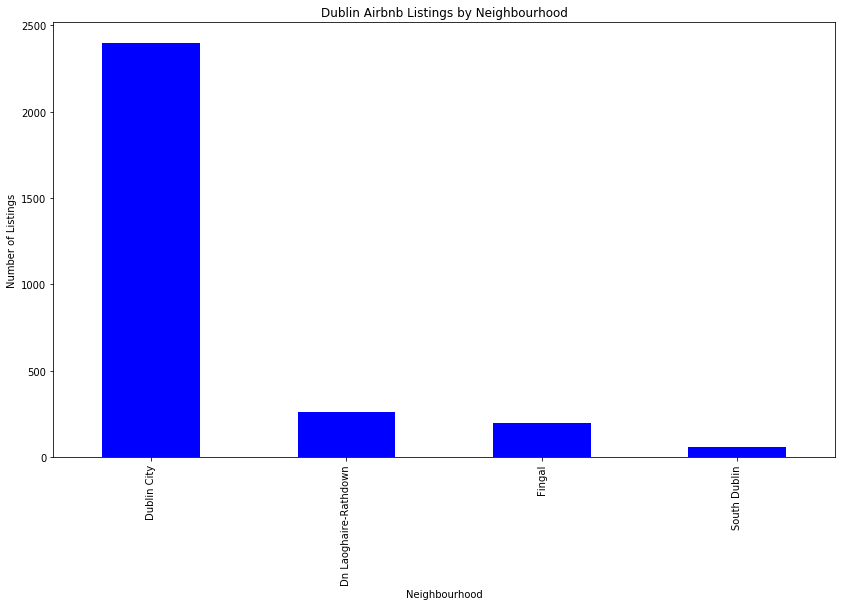

In [38]:
# Generate bar chart to show number of relevant listings in Dublin by neighbourhooddf = df.replace(np.nan,0)
dubHist_df = dubListFinal_df['neighbourhood'].value_counts().plot(kind='bar', color = 'b',
                                    figsize=(14,8),
                                    title="Dublin Airbnb Listings by Neighbourhood")
dubHist_df.set_xlabel("Neighbourhood")
dubHist_df.set_ylabel("Number of Listings")

In [39]:
# Determine mean, median, maximum and minimum max_annual_earnings for Dublin
# mean Dublin max_annual_earnings by neighbourhood
dubMean = dubListFinal_df.groupby('neighbourhood')['max_annual_earnings'].mean()
print(round(dubMean))

neighbourhood
Dn Laoghaire-Rathdown    28899.0
Dublin City              28849.0
Fingal                   22708.0
South Dublin             23232.0
Name: max_annual_earnings, dtype: float64


In [40]:
# median Dublin max_annual_earnings by neighbourhood
dubMedian = dubListFinal_df.groupby('neighbourhood')['max_annual_earnings'].median()
print(round(dubMedian))

neighbourhood
Dn Laoghaire-Rathdown    15990.0
Dublin City              13400.0
Fingal                   16272.0
South Dublin              9654.0
Name: max_annual_earnings, dtype: float64


In [41]:
# maximum max_annual_earnings Dublin by neighbourhood
dubMax = dubListFinal_df.groupby('neighbourhood')['max_annual_earnings'].max()
print(round(dubMax))

neighbourhood
Dn Laoghaire-Rathdown     345000
Dublin City              1128400
Fingal                    235200
South Dublin              327000
Name: max_annual_earnings, dtype: int64


In [42]:
# minimum max_annual_earnings Dublin by neighbourhood
dubMin = dubListFinal_df.groupby('neighbourhood')['max_annual_earnings'].min()
print(round(dubMin))

neighbourhood
Dn Laoghaire-Rathdown    150
Dublin City               40
Fingal                    90
South Dublin              76
Name: max_annual_earnings, dtype: int64


In [43]:
# Create dataframe to summarize Dublin max_annual_earning statistics
neighbourhood = ['Dun Laoghaire Rathdown', 'Dublin City', 'Fingal', 'South Dublin']
dubStat = pd.DataFrame(list(zip(neighbourhood, round(dubMean), round(dubMedian), round(dubMax), round(dubMin))),
                      columns =['Neighbourhood', 'Mean', 'Median', 'Maximum', 'Minimum'])
dubStat.head()

Neighbourhood     Mean   Median  Maximum  Minimum
0  Dun Laoghaire Rathdown  28899.0  15990.0   345000      150
1             Dublin City  28849.0  13400.0  1128400       40
2                  Fingal  22708.0  16272.0   235200       90
3            South Dublin  23232.0   9654.0   327000       76

In [44]:
# show unique neighbourhoods in Cork
print(corListFinal_df.neighbourhood.unique())

['Cork City South Central ' 'Cork City North East '
 'Cork City North West ' 'Cork City South West ' 'Cork City South East ']


Text(0, 0.5, 'Number of Listings')

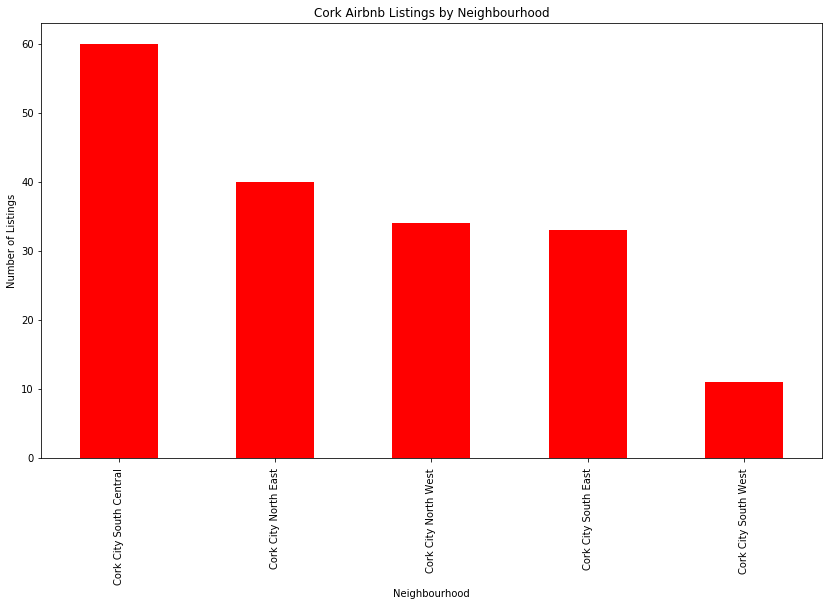

In [45]:
# Generate histogram to show number of relevant listings in Cork by neighbourhood
corHist_df = corListFinal_df['neighbourhood'].value_counts().plot(kind='bar', color = 'r',
                                    figsize=(14,8),
                                    title="Cork Airbnb Listings by Neighbourhood")
corHist_df.set_xlabel("Neighbourhood")
corHist_df.set_ylabel("Number of Listings")

In [46]:
# Determine mean, median, maximum and minimum max_annual_earnings by neighbourhood for Cork
# mean Cork max_annual_earnings by neighbourhood
corMean = corListFinal_df.groupby('neighbourhood')['max_annual_earnings'].mean()
print(round(corMean))

neighbourhood
Cork City North East        26679.0
Cork City North West        20056.0
Cork City South Central     21003.0
Cork City South East        21377.0
Cork City South West        23515.0
Name: max_annual_earnings, dtype: float64


In [47]:
# median Cork max_annual_earnings by neighbourhood
corMedian = corListFinal_df.groupby('neighbourhood')['max_annual_earnings'].mean()
print(round(corMedian))

neighbourhood
Cork City North East        26679.0
Cork City North West        20056.0
Cork City South Central     21003.0
Cork City South East        21377.0
Cork City South West        23515.0
Name: max_annual_earnings, dtype: float64


In [48]:
# max Cork max_annual_earnings by neighbourhood
corMax = corListFinal_df.groupby('neighbourhood')['max_annual_earnings'].max()
print(round(corMax))

neighbourhood
Cork City North East        122150
Cork City North West         84250
Cork City South Central     109800
Cork City South East         60400
Cork City South West        110360
Name: max_annual_earnings, dtype: int64


In [49]:
# min Cork max_annual_earnings by neighbourhood
corMin = corListFinal_df.groupby('neighbourhood')['max_annual_earnings'].min()
print(round(corMin))

neighbourhood
Cork City North East         70
Cork City North West        325
Cork City South Central     639
Cork City South East        524
Cork City South West        120
Name: max_annual_earnings, dtype: int64


In [50]:
# Create dataframe to summarize Cork max_annual_earning statistics
neighbourhoodC = ['Cork City North East', 'Cork City North West', 'Cork City South Central', 'Cork City South East', 'Cork City South West']
corStat = pd.DataFrame(list(zip(neighbourhoodC, round(corMean), round(corMedian), round(corMax), round(corMin))),
                      columns =['Neighbourhood', 'Mean', 'Median', 'Maximum', 'Minimum'])
corStat.head()

Neighbourhood     Mean   Median  Maximum  Minimum
0     Cork City North East  26679.0  26679.0   122150       70
1     Cork City North West  20056.0  20056.0    84250      325
2  Cork City South Central  21003.0  21003.0   109800      639
3     Cork City South East  21377.0  21377.0    60400      524
4     Cork City South West  23515.0  23515.0   110360      120

# Dublin Geospatial Analysis

In [51]:
# Use geopy library to get geographical co-ordinates for Dublin
address = 'Dublin, Ireland'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
dublatitude = location.latitude
dublongitude = location.longitude
print('The geograpical coordinate of Dublin are {}, {}.'.format(dublatitude, dublongitude))


The geograpical coordinate of Dublin are 53.3497645, -6.2602732.


In [52]:
# Create folium map for Dublin
dub_map = folium.Map(location=[dublatitude, dublongitude], zoom_start=11)
dub_map

In [53]:
# Generate a reduced dataset of 1,000 listings for visualization purposes as 2,912 listings are too large to visualize on a folium map
reddubListFinal_df = dubListFinal_df.head(1000)

# Add markers to the Dublin map for each of the Airbnb Listings
for dlat, dlong, dident in zip(reddubListFinal_df['latitude'], reddubListFinal_df['longitude'], reddubListFinal_df['id']):
    label = "{}".format(dident)
    popup = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [dlat, dlong],
        radius=5,
        popup=popup,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(dub_map)
    
dub_map

## Perform Kmeans Clustering on Dublin Airbnb Listings

In [55]:
# Create new datframe with just id and latittude, longitude for Dublin Airbnb Listing (only Dublin City Centre)

# Remove non City Centre listings
reddubListFinal2_df = reddubListFinal_df[reddubListFinal_df.neighbourhood == 'Dublin City']
reddubListFinal2_df.head(10)

# Create datframe with just id, latitude and longitude
dubKclust_df=reddubListFinal2_df.loc[:,['id','latitude','longitude']]
dubKclust_df.head(10)

id  latitude  longitude
0   165828  53.33630   -6.32439
1   165829  53.33811   -6.32259
3   237465  53.39615   -6.17456
4   275425  53.32670   -6.20921
6   302554  53.35628   -6.28981
7   302634  53.35561   -6.29149
8   365854  53.35305   -6.25708
9   374792  53.33680   -6.32410
10  386860  53.33759   -6.27460
11  419987  53.35651   -6.29229

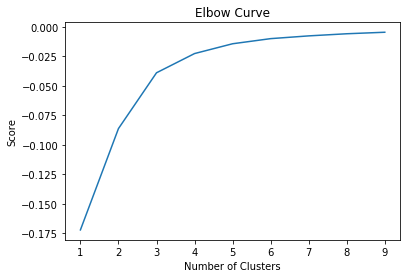

In [56]:
# Create Elbow curve to determine correct number of clusters
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = dubKclust_df[['latitude']]
X_axis = dubKclust_df[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [57]:
# Perform kmeans clustering on Dublin Airbnb and add to datframe
kmeans = KMeans(n_clusters = 5, init ='k-means++')
kmeans.fit(dubKclust_df[dubKclust_df.columns[1:3]]) # Compute k-means clustering.
dubKclust_df['cluster_label'] = kmeans.fit_predict(dubKclust_df[dubKclust_df.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(dubKclust_df[dubKclust_df.columns[1:3]]) # Labels of each point
dubKclust_df.head(100)

id  latitude  longitude  cluster_label
0     165828  53.33630   -6.32439              4
1     165829  53.33811   -6.32259              4
3     237465  53.39615   -6.17456              3
4     275425  53.32670   -6.20921              1
6     302554  53.35628   -6.28981              2
7     302634  53.35561   -6.29149              4
8     365854  53.35305   -6.25708              2
9     374792  53.33680   -6.32410              4
10    386860  53.33759   -6.27460              2
11    419987  53.35651   -6.29229              4
12    424596  53.35456   -6.25886              2
13    427077  53.35593   -6.25751              2
14    451611  53.34109   -6.27175              2
15    454183  53.35391   -6.29800              4
16    522667  53.35526   -6.25734              2
17    526767  53.34769   -6.26388              2
18    654589  53.34489   -6.26804              2
23    800026  53.36825   -6.25039              1
24    816039  53.36609   -6.32459              4
26    872539  53.35799   -6.23991              1
27    922425  53.34248   -6.27240              2
28    928970  53.34246   -6.23910              1
29    939866  53.34370   -6.23975              1
30    946923  53.34539   -6.23873              1
31    998407  53.39729   -6.17521              3
32    999963  53.36181   -6.27475              2
33   1076514  53.34652   -6.24697              1
34   1086416  53.35787   -6.27497              2
36   1265520  53.36777   -6.27172              2
37   1276002  53.35190   -6.23396              1
..       ...       ...        ...            ...
85   3096382  53.34466   -6.26698              2
87   3238040  53.32871   -6.25337              0
91   3345276  53.34249   -6.26706              2
92   3374950  53.35732   -6.24464              1
93   3389175  53.34013   -6.27371              2
94   3411757  53.33867   -6.30322              4
95   3448070  53.34168   -6.30349              4
96   3495749  53.33424   -6.29294              4
97   3529607  53.33464   -6.29369              4
98   3540733  53.31075   -6.28624              0
99   3550489  53.38057   -6.23695              1
100  3591840  53.33398   -6.29307              4
101  3592153  53.33199   -6.22741              1
102  3592455  53.33672   -6.25631              0
103  3604420  53.34681   -6.22693              1
104  3604440  53.34231   -6.23590              1
105  3634410  53.33832   -6.23847              1
106  3634993  53.33363   -6.28174              0
107  3665546  53.34796   -6.26511              2
108  3795879  53.34504   -6.26857              2
109  3850497  53.35854   -6.26933              2
110  3858756  53.34259   -6.27110              2
112  3882631  53.32570   -6.25044              0
114  3964994  53.38567   -6.21643              3
118  4059266  53.34414   -6.23518              1
119  4172796  53.33263   -6.25432              0
120  4195273  53.33517   -6.22276              1
121  4216882  53.33754   -6.33081              4
122  4216958  53.34629   -6.26471              2
123  4261174  53.31737   -6.31720              4

[100 rows x 4 columns]

In [58]:
# Visualize clusters on map of Dublin City Centre
# create map

kclusters = 5

dubmap_clusters = folium.Map(location=[dublatitude, dublongitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, id, cluster in zip(dubKclust_df['latitude'], dubKclust_df['longitude'], dubKclust_df['id'], dubKclust_df['cluster_label']):
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(dubmap_clusters)
       
dubmap_clusters

The cluster analysis shows 5 clusters centred around Mary Street, Islandbridge, Rathmines, Hanover Street and a smaller cluster at Raheny.
Rather than explore all venues, it was decided to explore three venues that looked particularly popular to see what makes them so poular with Airbnb clients - Mary Street, Sir John Rogerson's Quay and Rathmines

## Use Foursquare API to explore venues in four Dublin City Clusters (Mary Street, Sir John Rogerson's Quay, Rathmines and Kilmainham)

In [59]:
# Use geopy library to get geographical co-ordinates for Mary Street, Dublin
address = 'Mary Street, Dublin, Ireland'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
marylatitude = location.latitude
marylongitude = location.longitude
print('The geograpical coordinate of Mary Street, Dublin are {}, {}.'.format(marylatitude, marylongitude))

The geograpical coordinate of Mary Street, Dublin are 53.3485652, -6.2680657.


In [60]:
# Use geopy library to get geographical co-ordinates for Sir John Rogersons Quay, Dublin
address = 'Sir John Rogersons Quay, Dublin, Ireland'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
roglatitude = location.latitude
roglongitude = location.longitude
print('The geograpical coordinate of Sir John Rogersons Quay Dublin are {}, {}.'.format(roglatitude, roglongitude))

The geograpical coordinate of Sir John Rogersons Quay Dublin are 53.3456707, -6.2342947.


In [61]:
# Use geopy library to get geographical co-ordinates for Rathmines, Dublin
address = 'Rathmines, Dublin, Ireland'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
rathlatitude = location.latitude
rathlongitude = location.longitude
print('The geograpical coordinate of Rathmines, Dublin are {}, {}.'.format(rathlatitude, rathlongitude))

The geograpical coordinate of Rathmines, Dublin are 53.3265199, -6.2648571.


In [ ]:
# Use geopy library to get geographical co-ordinates for Kilmainham, Dublin
address = 'KilmainhamIreland'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
rathlatitude = location.latitude
rathlongitude = location.longitude
print('The geograpical coordinate of Rathmines, Dublin are {}, {}.'.format(rathlatitude, rathlongitude))

In [62]:
# Access Foursquare API

CLIENT_ID = 'JXVETAYDYL2KYQXYGROHGMZFPA0C1L34ORVUO2LVO3D2H0Y1' # your Foursquare ID
CLIENT_SECRET = 'U3TG2OKOUA5FXKXWUSRBWK022LG4CGUZRV4EZD0PSP2WASPS' # your Foursquare Secret

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
VERSION = '20200202'

Your credentials:
CLIENT_ID: JXVETAYDYL2KYQXYGROHGMZFPA0C1L34ORVUO2LVO3D2H0Y1
CLIENT_SECRET:U3TG2OKOUA5FXKXWUSRBWK022LG4CGUZRV4EZD0PSP2WASPS


In [63]:
# Create radius of 1km and limit of 100 venues
radius = 1000
LIMIT = 100

In [64]:
# create the API request URL to serach for venues near Mary Street
url = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    marylatitude,
    marylongitude,
    radius,
    LIMIT)
maryresults = requests.get(url).json() 
maryresults

{'meta': {'code': 200, 'requestId': '5e3a7b130f5968001b989bce'},
 'response': {'venues': [{'id': '5cb5be410a08ab002c5e0650',
    'name': 'Umi Falafel',
    'location': {'address': '4 Mary Street',
     'lat': 53.348507,
     'lng': -6.2681875,
     'labeledLatLngs': [{'label': 'display',
       'lat': 53.348507,
       'lng': -6.2681875}],
     'distance': 10,
     'postalCode': 'D01 KR89',
     'cc': 'IE',
     'country': 'Ireland',
     'formattedAddress': ['4 Mary Street', 'Ireland']},
    'categories': [{'id': '4bf58dd8d48988d10b941735',
      'name': 'Falafel Restaurant',
      'pluralName': 'Falafel Restaurants',
      'shortName': 'Falafel',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/falafel_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1580891016',
    'hasPerk': False},
   {'id': '4b76c753f964a5208b5e2ee3',
    'name': 'Madina Desi Curry Co',
    'location': {'address': '60 Mary St',
     'lat': 53.3485648425116,
     'ln

In [65]:
# assign relevant part of JSON to Mary Street venues
maryvenues = maryresults['response']['venues']

# tranform venues into a dataframe
mary_df = json_normalize(maryvenues)
mary_df.head(10)

categories  hasPerk  \
0  [{'id': '4bf58dd8d48988d10b941735', 'name': 'F...    False   
1  [{'id': '4bf58dd8d48988d10f941735', 'name': 'I...    False   
2                                                 []    False   
3  [{'id': '4bf58dd8d48988d10f941735', 'name': 'I...    False   
4  [{'id': '52f2ab2ebcbc57f1066b8b1b', 'name': 'S...    False   
5  [{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...    False   
6  [{'id': '52e81612bcbc57f1066b79ed', 'name': 'O...    False   
7  [{'id': '4bf58dd8d48988d103951735', 'name': 'C...    False   
8  [{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...    False   
9  [{'id': '4bf58dd8d48988d17f941735', 'name': 'M...    False   

                         id        location.address location.cc location.city  \
0  5cb5be410a08ab002c5e0650           4 Mary Street          IE           NaN   
1  4b76c753f964a5208b5e2ee3              60 Mary St          IE        Dublin   
2  500e6aefe4b0f6032ec15a03           Jervis Street          IE        Dublin   
3  4d8e42a5788c5481aef534fd  60 Mary St, North City          IE           NaN   
4  5757f901498efe7dbe772979                     NaN          IE        Dublin   
5  5627764f498e1e14fbc37208           6 Mary Street          IE        Dublin   
6  4cb96d02035d236a7fc9d34e  O'Connell Street Lower          IE        Dublin   
7  4cde7cbb94c3b60c149965ea                     NaN          IE           NaN   
8  4d232806f7a9a143ccbc459f              64 Mary St          IE        Dublin   
9  594d9dea6eda024e0a07d2c6                     NaN          IE           NaN   

  location.country location.crossStreet  location.distance  \
0          Ireland                  NaN                 10   
1          Ireland                  NaN                  5   
2          Ireland                  NaN                 94   
3          Ireland                  NaN                  8   
4          Ireland                  NaN                 21   
5          Ireland                  NaN                 20   
6          Ireland  Prince Street North                545   
7          Ireland                  NaN                 21   
8          Ireland                  NaN                 27   
9          Ireland                  NaN                 32   

                           location.formattedAddress  \
0                           [4 Mary Street, Ireland]   
1         [60 Mary St, Dublin, Dublin City, Ireland]   
2      [Jervis Street, Dublin, Dublin City, Ireland]   
3                  [60 Mary St, North City, Ireland]   
4                     [Dublin, Dublin City, Ireland]   
5      [6 Mary Street, Dublin, Dublin City, Ireland]   
6  [O'Connell Street Lower (Prince Street North),...   
7                                          [Ireland]   
8         [64 Mary St, Dublin, Dublin City, Ireland]   
9                                          [Ireland]   

                             location.labeledLatLngs  location.lat  \
0  [{'label': 'display', 'lat': 53.348507, 'lng':...     53.348507   
1  [{'label': 'display', 'lat': 53.3485648425116,...     53.348565   
2  [{'label': 'display', 'lat': 53.34864985335915...     53.348650   
3  [{'label': 'display', 'lat': 53.34848694999999...     53.348487   
4  [{'label': 'display', 'lat': 53.348601, 'lng':...     53.348601   
5  [{'label': 'display', 'lat': 53.348405, 'lng':...     53.348405   
6  [{'label': 'display', 'lat': 53.34903136760773...     53.349031   
7  [{'label': 'display', 'lat': 53.348634, 'lng':...     53.348634   
8  [{'label': 'display', 'lat': 53.34851821341862...     53.348518   
9  [{'label': 'display', 'lat': 53.34881591796875...     53.348816   

   location.lng location.neighborhood location.postalCode location.state  \
0     -6.268187                   NaN            D01 KR89            NaN   
1     -6.268151                   NaN                   1    Dublin City   
2     -6.266651                   NaN                 NaN    Dublin City   
3     -6.268088                   NaN            DUBLIN 1  

In [66]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in mary_df.columns if col.startswith('location.')] + ['id']
mary_df_filtered = mary_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
mary_df_filtered['categories'] = mary_df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
mary_df_filtered.columns = [column.split('.')[-1] for column in mary_df_filtered.columns]

mary_df_filtered.head()

name          categories  \
0                                        Umi Falafel  Falafel Restaurant   
1                               Madina Desi Curry Co   Indian Restaurant   
2  The Church CafÃÂ© Bar, Restaurant, Club and T...                None   
3                                             Madina   Indian Restaurant   
4                              Carroll's Irish Gifts       Souvenir Shop   

                  address  cc    city  country crossStreet  distance  \
0           4 Mary Street  IE     NaN  Ireland         NaN        10   
1              60 Mary St  IE  Dublin  Ireland         NaN         5   
2           Jervis Street  IE  Dublin  Ireland         NaN        94   
3  60 Mary St, North City  IE     NaN  Ireland         NaN         8   
4                     NaN  IE  Dublin  Ireland         NaN        21   

                                formattedAddress  \
0                       [4 Mary Street, Ireland]   
1     [60 Mary St, Dublin, Dublin City, Ireland]   
2  [Jervis Street, Dublin, Dublin City, Ireland]   
3              [60 Mary St, North City, Ireland]   
4                 [Dublin, Dublin City, Ireland]   

                                      labeledLatLngs        lat       lng  \
0  [{'label': 'display', 'lat': 53.348507, 'lng':...  53.348507 -6.268187   
1  [{'label': 'display', 'lat': 53.3485648425116,...  53.348565 -6.268151   
2  [{'label': 'display', 'lat': 53.34864985335915...  53.348650 -6.266651   
3  [{'label': 'display', 'lat': 53.34848694999999...  53.348487 -6.268088   
4  [{'label': 'display', 'lat': 53.348601, 'lng':...  53.348601 -6.268389   

  neighborhood postalCode        state                        id  
0          NaN   D01 KR89          NaN  5cb5be410a08ab002c5e0650  
1          NaN          1  Dublin City  4b76c753f964a5208b5e2ee3  
2          NaN        NaN  Dublin City  500e6aefe4b0f6032ec15a03  
3          NaN   DUBLIN 1          NaN  4d8e42a5788c5481aef534fd  
4          NaN   DUBLIN 1  Dublin City  5757f901498efe7dbe772979

In [67]:
# Remove unnecessary columns to generate final Mary Street venues listings dataframe
maryFinal_df = mary_df_filtered.drop(['cc', 'city', 'country', 'crossStreet', 'formattedAddress', 'labeledLatLngs', 
                             'neighborhood', 'postalCode', 'state'], axis=1).reset_index(drop=True)
maryFinal_df

name  \
0                                         Umi Falafel   
1                                Madina Desi Curry Co   
2   The Church CafÃÂ© Bar, Restaurant, Club and T...   
3                                              Madina   
4                               Carroll's Irish Gifts   
5                     Quick Pizza & Peri Peri Chicken   
6                                   Jim Larkin Statue   
7                                       Rambler's Way   
8                                     The Coffee Bean   
9                                Erotica Adult Cinema   
10                           Mr Middleton Garden Shop   
11                                     Slattery's Bar   
12                                           Lenehans   
13                                              Arisu   
14                                    Little Dumpling   
15                                              Krewe   
16                                         McDonald's   
17                          Bullet Duck And Dumplings   
18                               Super Asia Food 恒辉食品   
19                                          glamworld   
20                                           McNeills   
21                                    The Virgin Mary   
22                                    Wolfe Tone Park   
23                                    Banba Toymaster   
24                                             Centra   
25                                                AIB   
26                                     Vintage Dublin   
27                                  Asian Food Market   
28                                         The Church   
29                                             Aobaba   
..                                                ...   
70                                                海兰江   
71                                        Slikkentiss   
72                                             King 7   
73                                      Capel Camping   
74          Dublin Port - Stena Railway Station (DPS)   
75                                      LOCKSMITHS.IE   
76                                     Ja Ja, Nou Nou   
77                                 Ha Salon / Sunbeds   
78                                                Rua   
79                                     Elvis Fan Club   
80                                                川外川   
81                                    House Of Colour   
82                                      Soneil Studio   
83                                      Careers Coach   
84                                      Spicy Village   
85                                     POW E-Learning   
86                                             Zero-g   
87                                             Oxegen   
88                                  Brenfer Jewellers   
89                                       MCO projects   
90                        Easy Teeth Whitening Studio   
91                                      Aidan Doherty   
92                                  Amworks Coworking   
93                                      goodtoknow HQ   
94        IPB - Intercâmbio para Brasileiros (Dublin)   
95                                        Dublin ISRS   
96                              Martin Gear Jewellers   
97                                              Storm   
98                                   25 Wolfe Tone st   
99                                  Dublin Comic Mart   

                                  categories                        address  \
0                         Falafel Restaurant                  4 Mary Street   
1                          Indian Restaurant                     60 Mary St   
2                                       None                  Jervis Street   
3                          Indian Restaurant         60 Mary St, North City   
4                              Souvenir Shop                            NaN   
5                                Pizza P

Text(0, 0.5, 'Number of Venues')

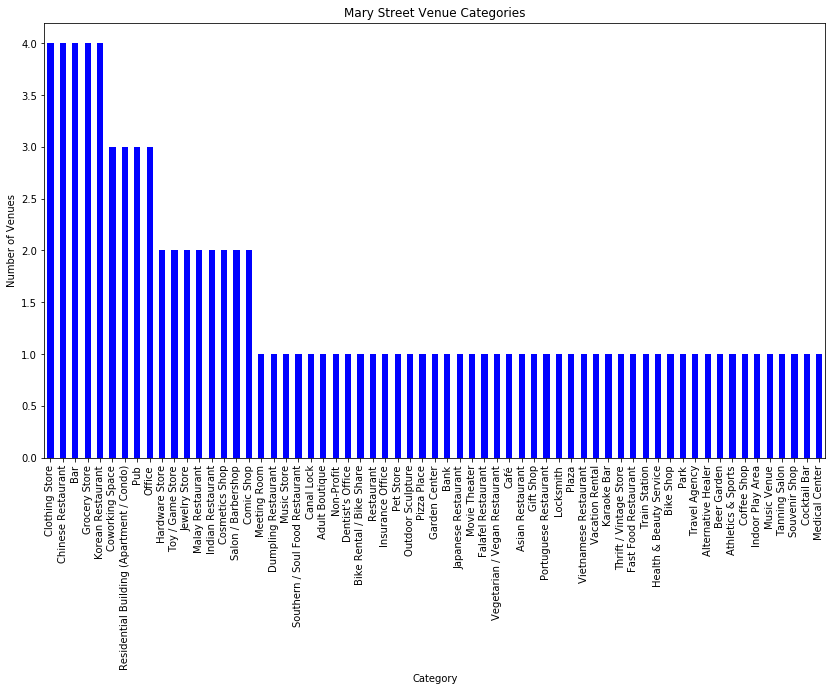

In [68]:
# Generate bar chart to show categories of venues near Mary Street
maryHist_df = maryFinal_df['categories'].value_counts().plot(kind='bar', color = 'b',
                                    figsize=(14,8),
                                    title="Mary Street Venue Categories")
maryHist_df.set_xlabel("Category")
maryHist_df.set_ylabel("Number of Venues")

In [69]:
# create the API request URL to serach for venues near Sir John Rogersons Quay
url = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    roglatitude,
    roglongitude,
    radius,
    LIMIT)
rogresults = requests.get(url).json() 
rogresults

{'meta': {'code': 200, 'requestId': '5e3a7be9df2774001b7d5ae8'},
 'response': {'venues': [{'id': '4d77d253a7e6b1f74e9a2bdf',
    'name': 'Matheson',
    'location': {'address': "70 Sir John Rogerson's Quay",
     'lat': 53.34528671612497,
     'lng': -6.233475208282471,
     'labeledLatLngs': [{'label': 'display',
       'lat': 53.34528671612497,
       'lng': -6.233475208282471}],
     'distance': 69,
     'postalCode': '2',
     'cc': 'IE',
     'city': 'Dublin',
     'state': 'Dublin City',
     'country': 'Ireland',
     'formattedAddress': ["70 Sir John Rogerson's Quay",
      'Dublin',
      'Dublin City',
      'Ireland']},
    'categories': [{'id': '4bf58dd8d48988d124941735',
      'name': 'Office',
      'pluralName': 'Offices',
      'shortName': 'Office',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/default_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1580891022',
    'hasPerk': False},
   {'id': '4b1fe4c3f964a5205f2

In [70]:
# assign relevant part of JSON to Sir John Rogersons Quay venues
rogvenues = rogresults['response']['venues']

# tranform venues into a dataframe
rog_df = json_normalize(rogvenues)
rog_df.head()

categories  hasPerk  \
0  [{'id': '4bf58dd8d48988d124941735', 'name': 'O...    False   
1                                                 []    False   
2  [{'id': '4bf58dd8d48988d12d951735', 'name': 'B...    False   
3  [{'id': '4bf58dd8d48988d124941735', 'name': 'O...    False   
4  [{'id': '52e81612bcbc57f1066b79ed', 'name': 'O...    False   

                         id             location.address location.cc  \
0  4d77d253a7e6b1f74e9a2bdf  70 Sir John Rogerson's Quay          IE   
1  4b1fe4c3f964a5205f2a24e3          John Rogersons Quay          IE   
2  5dbd77935dec290008c47e3b                          NaN          IE   
3  4f216cc7e4b0b5801b90a9e5  Sir John Rogerson's Quay 56          IE   
4  5d908c2cf180cd0008de4250                          NaN          IE   

  location.city location.country location.crossStreet  location.distance  \
0        Dublin          Ireland                  NaN                 69   
1        Dublin          Ireland                  NaN                 34   
2        Dublin          Ireland                  NaN                 88   
3        Dublin          Ireland                  NaN                 66   
4        Dublin          Ireland                  NaN                 84   

                           location.formattedAddress  \
0  [70 Sir John Rogerson's Quay, Dublin, Dublin C...   
1  [John Rogersons Quay, Dublin, Dublin City, Ire...   
2                     [Dublin, Dublin City, Ireland]   
3  [Sir John Rogerson's Quay 56, Dublin, Dublin C...   
4                                  [Dublin, Ireland]   

                             location.labeledLatLngs  location.lat  \
0  [{'label': 'display', 'lat': 53.34528671612497...     53.345287   
1  [{'label': 'display', 'lat': 53.34563645739624...     53.345636   
2  [{'label': 'display', 'lat': 53.345954, 'lng':...     53.345954   
3  [{'label': 'display', 'lat': 53.34563258586094...     53.345633   
4  [{'label': 'display', 'lat': 53.345836, 'lng':...     53.345836   

   location.lng location.neighborhood location.postalCode location.state  \
0     -6.233475                   NaN                   2    Dublin City   
1     -6.234818                   NaN                 NaN    Dublin City   
2     -6.235543                   NaN            DUBLIN 2    Dublin City   
3     -6.235299                   NaN                   2    Dublin City   
4     -6.235529                   NaN            DUBLIN 2            NaN   

             name    referralId  
0        Matheson  v-1580891022  
1  MOP Solicitors  v-1580891022  
2    ARA Libertad  v-1580891022  
3             FMB  v-1580891022  
4         Gaswork  v-1580891022

In [71]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in rog_df.columns if col.startswith('location.')] + ['id']
rog_df_filtered = rog_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
rog_df_filtered['categories'] = rog_df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
rog_df_filtered.columns = [column.split('.')[-1] for column in rog_df_filtered.columns]

rog_df_filtered.head(10)

name         categories  \
0            Matheson             Office   
1      MOP Solicitors               None   
2        ARA Libertad      Boat or Ferry   
3                 FMB             Office   
4             Gaswork  Outdoor Sculpture   
5           Café Sora               Café   
6  Accenture The Dock             Office   
7              Indeed             Office   
8       Nave Vespucci      Boat or Ferry   
9               Fresh      Grocery Store   

                                             address  cc    city  country  \
0                        70 Sir John Rogerson's Quay  IE  Dublin  Ireland   
1                                John Rogersons Quay  IE  Dublin  Ireland   
2                                                NaN  IE  Dublin  Ireland   
3                        Sir John Rogerson's Quay 56  IE  Dublin  Ireland   
4                                                NaN  IE  Dublin  Ireland   
5                                                NaN  IE  Dublin  Ireland   
6                   7 Hanover Quay, Grand Canal Dock  IE  Dublin  Ireland   
7                        Sir John Rogerson‘s Quay 82  IE  Dublin  Ireland   
8                                                NaN  IE     NaN  Ireland   
9  Capital Dock, units 4&5 Stevens walk, Sir John...  IE  Dublin  Ireland   

  crossStreet  distance                                   formattedAddress  \
0         NaN        69  [70 Sir John Rogerson's Quay, Dublin, Dublin C...   
1         NaN        34  [John Rogersons Quay, Dublin, Dublin City, Ire...   
2         NaN        88                     [Dublin, Dublin City, Ireland]   
3         NaN        66  [Sir John Rogerson's Quay 56, Dublin, Dublin C...   
4         NaN        84                                  [Dublin, Ireland]   
5         NaN        54                     [Dublin, Dublin City, Ireland]   
6         NaN       183  [7 Hanover Quay, Grand Canal Dock, Dublin, Dub...   
7         NaN       188     [Sir John Rogerson‘s Quay 82, Dublin, Ireland]   
8         NaN        38                                          [Ireland]   
9         NaN       149  [Capital Dock, units 4&5 Stevens walk, Sir Joh...   

                                      labeledLatLngs        lat       lng  \
0  [{'label': 'display', 'lat': 53.34528671612497...  53.345287 -6.233475   
1  [{'label': 'display', 'lat': 53.34563645739624...  53.345636 -6.234818   
2  [{'label': 'display', 'lat': 53.345954, 'lng':...  53.345954 -6.235543   
3  [{'label': 'display', 'lat': 53.34563258586094...  53.345633 -6.235299   
4  [{'label': 'display', 'lat': 53.345836, 'lng':...  53.345836 -6.235529   
5  [{'label': 'display', 'lat': 53.34543777375258...  53.345438 -6.233580   
6  [{'label': 'display', 'lat': 53.34404355550254...  53.344044 -6.233819   
7  [{'label': 'display', 'lat': 53.345392, 'lng':...  53.345392 -6.231499   
8  [{'label': 'display', 'lat': 53.34594679736732...  53.345947 -6.234637   
9  [{'label': 'display', 'lat': 53.34523, 'lng': ...  53.345230 -6.232172   

            neighborhood postalCode        state                        id  
0                    NaN          2  Dublin City  4d77d253a7e6b1f74e9a2bdf  
1                    NaN        NaN  Dublin City  4b1fe4c3f964a5205f2a24e3  
2                    NaN   DUBLIN 2  Dublin City  5dbd77935dec290008c47e3b  
3                    NaN          2  Dublin City  4f216cc7e4b0b5801b90a9e5  
4                    NaN   DUBLIN 2          NaN  5d908c2cf180cd0008de4250  
5                    NaN   Dublin 8  Dublin City  4bed253e9868a593b1f35c46  
6                    NaN   D02 YN32  Dublin City  57f3965f498eb5093fe5eddd  
7                    NaN   DUBLIN 2          NaN  5c6d0e7983e380002b277488  
8                    NaN        NaN          NaN  5038ea79e4b0b68ee4526b51  
9  South-East Inner City          2          NaN  5e25b4a1e04f4900071c1638

In [72]:
# Remove unnecessary columns to generate final Temple Bar venues listings dataframe
rogFinal_df = rog_df_filtered.drop(['cc', 'city', 'country', 'crossStreet', 'formattedAddress', 'labeledLatLngs', 
                             'neighborhood', 'postalCode', 'state'], axis=1).reset_index(drop=True)
rogFinal_df

name  \
0                                  Matheson   
1                            MOP Solicitors   
2                              ARA Libertad   
3                                       FMB   
4                                   Gaswork   
5                                 Café Sora   
6                        Accenture The Dock   
7                                    Indeed   
8                             Nave Vespucci   
9                                     Fresh   
10                              Mackenzie’s   
11                           The Bottle Boy   
12                               The Mayson   
13                    Barque Eagle Tallship   
14                        State Street Bank   
15                              Tripadvisor   
16                              J.P. Morgan   
17                         Classic Hits 4FM   
18                             barque eagle   
19                           LogMeIn Dublin   
20                            Airbnb Dublin   
21               Buque Escuela Cuautçhtemoc   
22                   DublinBikes Station 66   
23                       L.E Samuel Beckett   
24                          Weber Shandwick   
25                               Pause Cafe   
26                                  LogMeIn   
27  Spaces - Dublin, Spaces South Docklands   
28                             Ancestry.com   
29                               Herbstreet   
..                                      ...   
43                              Informatica   
44       Patrick Lane & Company Accountants   
45                            Butlers Court   
46                      AIB Capital Markets   
47                               Latin Hall   
48                              Informatica   
49                           The Waterfront   
50                        Select Strategies   
51                            Game On Media   
52                           Ashville Media   
53                               Park House   
54                Dublin's Sunshine 106.8FM   
55                                Cimeworld   
56                                     Mops   
57                            S. S. Artemis   
58                            Longboat Quay   
59                   DublinBikes Station 90   
60                                The Place   
61                          The Place To Be   
62                  412 Longboat Quay north   
63                             فندق السعادة   
64                           Jon Jon Museum   
65                     Buque Escuela Guayas   
66                                       63   
67                               Saba To Go   
68                        Kings Of Concrete   
69                                 Calimero   
70                            Shannons Cafe   
71                Urban Retreat Art Gallery   
72                       Vallence & McGrath   

                                  categories  \
0                                     Office   
1                                       None   
2                              Boat or Ferry   
3                                     Office   
4                          Outdoor Sculpture   
5                                       Café   
6                                     Office   
7                                     Office   
8                              Boat or Ferry   
9                              Grocery Store   
10                Modern European Restaurant   
11                                 Gastropub   
12                                       Pub   
13                             Boat or Ferry   
14                                  Building   
15                              Tech Startup   
16                                    Office   
17                     Performing Arts Venue   
18                             Boat or Ferry   
19                                    Office   
20                              Tech Startup   
21                             Boat or Ferry   
22                  

Text(0, 0.5, 'Number of Venues')

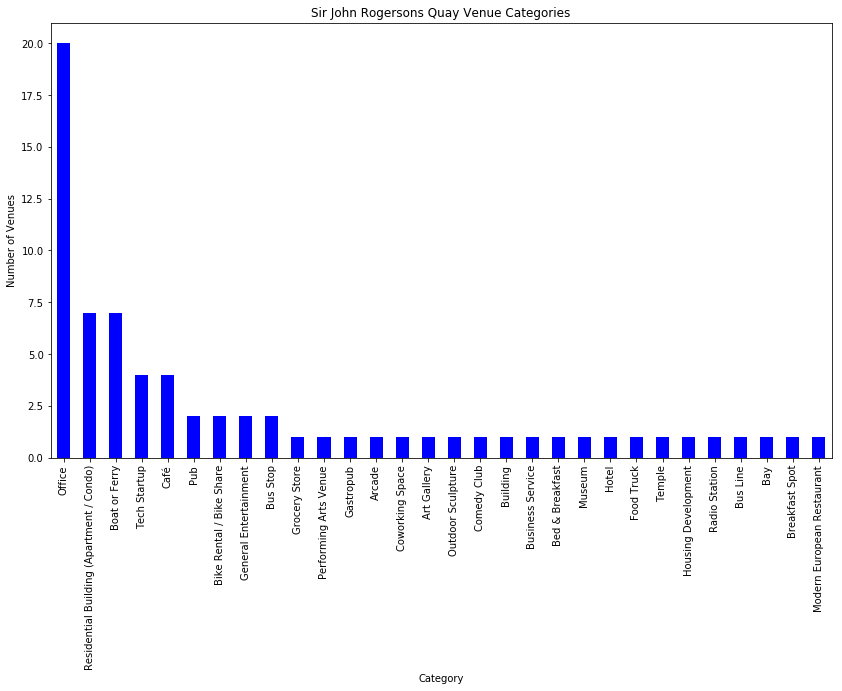

In [73]:
# Generate bar chart to show categories of venues in Temple Bar
rogHist_df = rogFinal_df['categories'].value_counts().plot(kind='bar', color = 'b',
                                    figsize=(14,8),
                                    title="Sir John Rogersons Quay Venue Categories")
rogHist_df.set_xlabel("Category")
rogHist_df.set_ylabel("Number of Venues")

In [74]:
# create the API request URL to search for venues in Rathmines
url = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    rathlatitude,
    rathlongitude,
    radius,
    LIMIT)
rathresults = requests.get(url).json() 
rathresults

{'meta': {'code': 200, 'requestId': '5e3a7b98c8cff2001b50225f'},
 'response': {'venues': [{'id': '5c7be3b0b9a5a8002cf2801d',
    'name': 'Hillbilly’s',
    'location': {'lat': 53.326484,
     'lng': -6.264952,
     'labeledLatLngs': [{'label': 'display',
       'lat': 53.326484,
       'lng': -6.264952}],
     'distance': 7,
     'postalCode': 'DUBLIN 6',
     'cc': 'IE',
     'city': 'Dublin',
     'country': 'Ireland',
     'formattedAddress': ['Dublin', 'Ireland']},
    'categories': [{'id': '4bf58dd8d48988d16e941735',
      'name': 'Fast Food Restaurant',
      'pluralName': 'Fast Food Restaurants',
      'shortName': 'Fast Food',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/fastfood_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1580891040',
    'hasPerk': False},
   {'id': '5d3ca8dae5486f0008013e87',
    'name': 'Uno',
    'location': {'address': 'Rathmines',
     'lat': 53.32654,
     'lng': -6.264989,
     'labeledLatLngs': [

In [75]:
# assign relevant part of JSON to Rathmines venues
rathvenues = rathresults['response']['venues']

# tranform venues into a dataframe
rath_df = json_normalize(rathvenues)
rath_df.head(10)

categories  hasPerk  \
0  [{'id': '4bf58dd8d48988d16e941735', 'name': 'F...    False   
1  [{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...    False   
2  [{'id': '4bf58dd8d48988d118951735', 'name': 'G...    False   
3  [{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...    False   
4  [{'id': '4bf58dd8d48988d102941735', 'name': 'Y...    False   
5  [{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...    False   
6  [{'id': '4bf58dd8d48988d11b941735', 'name': 'P...    False   
7  [{'id': '4d4ae6fc7a7b7dea34424761', 'name': 'F...    False   
8  [{'id': '4d1cf8421a97d635ce361c31', 'name': 'T...    False   
9  [{'id': '4bf58dd8d48988d178941735', 'name': 'D...    False   

                         id                     location.address location.cc  \
0  5c7be3b0b9a5a8002cf2801d                                  NaN          IE   
1  5d3ca8dae5486f0008013e87                            Rathmines          IE   
2  4b7aca43f964a520e73c2fe3    101 Lower Rathmines Rd, Rathmines          IE   
3  4bd0e077046076b03df07071           88-90 Lower Rathmines Road          IE   
4  4c7be841794e224bc9ac6c28  St Mary's College, Lwr Rathmines Rd          IE   
5  53566061498e03ae386c8305                     Rathmines Rd Lwr          IE   
6  5391f4fd498e1d03a72c5974                     Rathmines Rd Lwr          IE   
7  560bea21498e477634a094e4                                  NaN          IE   
8  4f2c09f2e4b0c0809d810fb6                  96 Rathmines Rd Lwr          IE   
9  57e37cfc498e591ff4c2b1e5    19 Grove Road Rathmines, Dublin 6          IE   

  location.city location.country location.crossStreet  location.distance  \
0        Dublin          Ireland                  NaN                  7   
1        Dublin          Ireland                  NaN                  9   
2        Dublin          Ireland                  NaN                 22   
3        Dublin          Ireland                  NaN                 21   
4        Dublin          Ireland                  NaN                181   
5        Dublin          Ireland                  NaN                 24   
6        Dublin          Ireland                  NaN                 39   
7           NaN          Ireland                  NaN                 28   
8        Dublin          Ireland                  NaN                 23   
9     Rathmines          Ireland                  NaN                 12   

                           location.formattedAddress  \
0                                  [Dublin, Ireland]   
1                       [Rathmines, Dublin, Ireland]   
2  [101 Lower Rathmines Rd, Rathmines, Dublin, Du...   
3  [88-90 Lower Rathmines Road, Dublin, Dublin Ci...   
4  [St Mary's College, Lwr Rathmines Rd, Dublin, ...   
5   [Rathmines Rd Lwr, Dublin, Dublin City, Ireland]   
6   [Rathmines Rd Lwr, Dublin, Dublin City, Ireland]   
7                                          [Ireland]   
8  [96 Rathmines Rd Lwr, Dublin, Dublin City, Ire...   
9  [19 Grove Road Rathmines, Dublin 6, Rathmines,...   

                             location.labeledLatLngs  location.lat  \
0  [{'label': 'display', 'lat': 53.326484, 'lng':...     53.326484   
1  [{'label': 'display', 'lat': 53.32654, 'lng': ...     53.326540   
2  [{'label': 'display', 'lat': 53.326711, 'lng':...     53.326711   
3  [{'label': 'display', 'lat': 53.32668836627091...     53.326688   
4  [{'label': 'display', 'lat': 53.32729863437836...     53.327299   
5  [{'label': 'display', 'lat': 53.3263017841516,...     53.326302   
6  [{'label': 'display', 'lat': 53.32687089926742...     53.326871   
7  [{'label': 'display', 'lat': 53.32639061496717...     53.326391   
8  [{'label': 'display', 'lat': 53.32672836820805...     53.326728   
9  [{'label': 'display', 'lat': 53.32649024255605...     53.326490   

   location.lng location.postalCode location.state  \
0     -6.264952            DUBLIN 6            NaN   
1     -6.264989                 NaN            NaN   
2     -6.264961                   6    Dublin City   
3   

In [76]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in rath_df.columns if col.startswith('location.')] + ['id']
rath_df_filtered = rath_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
rath_df_filtered['categories'] = rath_df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
rath_df_filtered.columns = [column.split('.')[-1] for column in rath_df_filtered.columns]

rath_df_filtered.head(10)

name            categories  \
0                   Hillbilly’s  Fast Food Restaurant   
1                           Uno           Pizza Place   
2             Oriental Emporium         Grocery Store   
3                Domino's Pizza           Pizza Place   
4                Yoga Rathmines           Yoga Studio   
5        The Orange Tree Bakery        Sandwich Place   
6                     Blackbird                   Pub   
7  Grace's Famous Fried Chicken   Fried Chicken Joint   
8                   Muscle Shop         Tanning Salon   
9             Canal View Dental      Dentist's Office   

                               address  cc       city  country crossStreet  \
0                                  NaN  IE     Dublin  Ireland         NaN   
1                            Rathmines  IE     Dublin  Ireland         NaN   
2    101 Lower Rathmines Rd, Rathmines  IE     Dublin  Ireland         NaN   
3           88-90 Lower Rathmines Road  IE     Dublin  Ireland         NaN   
4  St Mary's College, Lwr Rathmines Rd  IE     Dublin  Ireland         NaN   
5                     Rathmines Rd Lwr  IE     Dublin  Ireland         NaN   
6                     Rathmines Rd Lwr  IE     Dublin  Ireland         NaN   
7                                  NaN  IE        NaN  Ireland         NaN   
8                  96 Rathmines Rd Lwr  IE     Dublin  Ireland         NaN   
9    19 Grove Road Rathmines, Dublin 6  IE  Rathmines  Ireland         NaN   

   distance                                   formattedAddress  \
0         7                                  [Dublin, Ireland]   
1         9                       [Rathmines, Dublin, Ireland]   
2        22  [101 Lower Rathmines Rd, Rathmines, Dublin, Du...   
3        21  [88-90 Lower Rathmines Road, Dublin, Dublin Ci...   
4       181  [St Mary's College, Lwr Rathmines Rd, Dublin, ...   
5        24   [Rathmines Rd Lwr, Dublin, Dublin City, Ireland]   
6        39   [Rathmines Rd Lwr, Dublin, Dublin City, Ireland]   
7        28                                          [Ireland]   
8        23  [96 Rathmines Rd Lwr, Dublin, Dublin City, Ire...   
9        12  [19 Grove Road Rathmines, Dublin 6, Rathmines,...   

                                      labeledLatLngs        lat       lng  \
0  [{'label': 'display', 'lat': 53.326484, 'lng':...  53.326484 -6.264952   
1  [{'label': 'display', 'lat': 53.32654, 'lng': ...  53.326540 -6.264989   
2  [{'label': 'display', 'lat': 53.326711, 'lng':...  53.326711 -6.264961   
3  [{'label': 'display', 'lat': 53.32668836627091...  53.326688 -6.264708   
4  [{'label': 'display', 'lat': 53.32729863437836...  53.327299 -6.267251   
5  [{'label': 'display', 'lat': 53.3263017841516,...  53.326302 -6.264924   
6  [{'label': 'display', 'lat': 53.32687089926742...  53.326871 -6.264804   
7  [{'label': 'display', 'lat': 53.32639061496717...  53.326391 -6.265219   
8  [{'label': 'display', 'lat': 53.32672836820805...  53.326728 -6.264857   
9  [{'label': 'display', 'lat': 53.32649024255605...  53.326490 -6.265039   

  postalCode        state                        id  
0   DUBLIN 6          NaN  5c7be3b0b9a5a8002cf2801d  
1        NaN          NaN  5d3ca8dae5486f0008013e87  
2          6  Dublin City  4b7aca43f964a520e73c2fe3  
3   D06 H7X3  Dublin City  4bd0e077046076b03df07071  
4          6  Dublin City  4c7be841794e224bc9ac6c28  
5          6  Dublin City  53566061498e03ae386c8305  
6          6  Dublin City  5391f4fd498e1d03a72c5974  
7        NaN          NaN  560bea21498e477634a094e4  
8          6  Dublin City  4f2c09f2e4b0c0809d810fb6  
9        NaN          NaN  57e37cfc498e591ff4c2b1e5

In [77]:
# Remove unnecessary columns to generate final Rathmines venues listings dataframe
rathFinal_df = rath_df_filtered.drop(['cc', 'city', 'country', 'crossStreet', 'formattedAddress', 'labeledLatLngs', 'postalCode', 'state'], axis=1).reset_index(drop=True)
rathFinal_df

name  \
0                           Hillbilly’s   
1                                   Uno   
2                     Oriental Emporium   
3                        Domino's Pizza   
4                        Yoga Rathmines   
5                The Orange Tree Bakery   
6                             Blackbird   
7          Grace's Famous Fried Chicken   
8                           Muscle Shop   
9                     Canal View Dental   
10                          Tanning Hub   
11                               Subway   
12                   The Balance Centre   
13                                 Aldi   
14     The Laundry and Drycleaning Shop   
15                    Cawley Nea / TBWA   
16            Central Statistics Office   
17                        Farmer Browns   
18                  Swan Leisure Centre   
19                       Pavillion View   
20                          Camile Thai   
21                 Irish Cancer Society   
22                         Hit The Spot   
23                              Chopped   
24           Stay In Dublin City (SIDC)   
25  DIT Conservatory of Music and Drama   
26                 Dublin Bus Stop 1020   
27                           Travelodge   
28                    Rathmines College   
29            Church of Mary Immaculate   
..                                  ...   
70                        DIT Rathmines   
71                              Clegg's   
72                 Shirley's Laundrette   
73                     Elvis Guesthouse   
74              Herman White Properties   
75                    The 3rd Policeman   
76                           Tarczyński   
77       Dublin Institute of Technology   
78                           Agency.com   
79                             Fun Tech   
80                   Chocolate & Treats   
81              Net House Internet Café   
82           Holy Trinity Church Office   
83                   Rathmines Pharmacy   
84                         MART Project   
85                          Hawker Cafe   
86          Rathmines Grill & Take Away   
87                   Looce's Irish Camp   
88                               Dwarka   
89                          The Jockeys   
90               Jacqui's Beauty Treats   
91                   Euro Giant Express   
92                     Karate Rathmines   
93                 Pololith Fruit & Veg   
94                            Manifesto   
95                         Tynan Pianos   
96                          Banana Tree   
97                               Habibi   
98                  Guama House Ireland   
99                                Toast   

                                  categories  \
0                       Fast Food Restaurant   
1                                Pizza Place   
2                              Grocery Store   
3                                Pizza Place   
4                                Yoga Studio   
5                             Sandwich Place   
6                                        Pub   
7                        Fried Chicken Joint   
8                              Tanning Salon   
9                           Dentist's Office   
10                             Tanning Salon   
11                            Sandwich Place   
12                        Physical Therapist   
13                               Supermarket   
14                           Laundry Service   
15                                    Office   
16                       Government Building   
17                                Restaurant   
18                      Gym / Fitness Center   
19  Residential Building (Apartment / Condo)   
20                           Thai Restaurant   
21                    Thrift / Vintage Store   
22                      Fast Food Restaurant   
23                               Salad Place   
24                                    Hostel   
25                     College Arts Building   
26                                  Bus Stop   
27                      

Text(0, 0.5, 'Number of Venues')

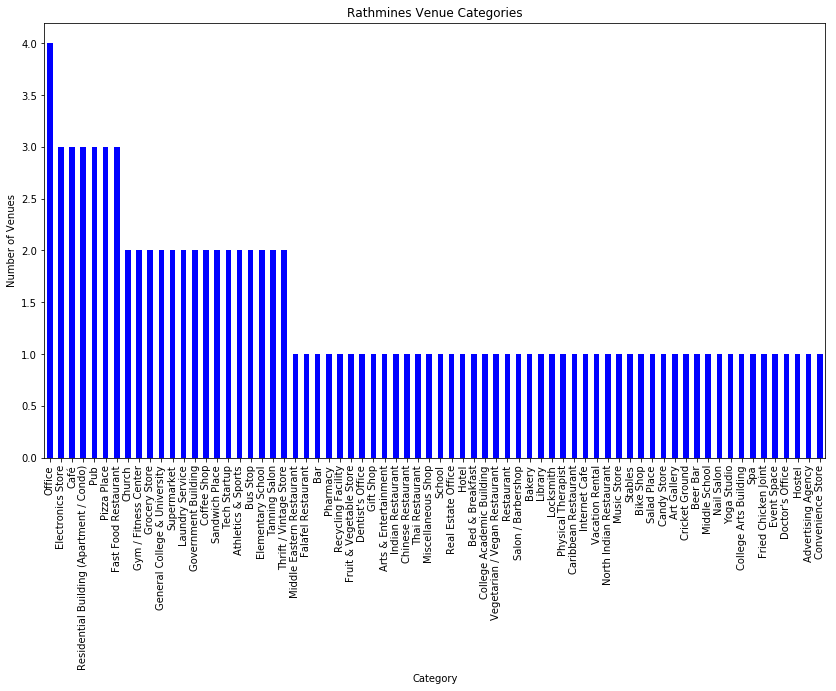

In [78]:
# Generate bar chart to show categories of venues in Rathmines
rathHist_df = rathFinal_df['categories'].value_counts().plot(kind='bar', color = 'b',
                                    figsize=(14,8),
                                    title="Rathmines Venue Categories")
rathHist_df.set_xlabel("Category")
rathHist_df.set_ylabel("Number of Venues")

# Cork Geospatial Analysis

In [79]:
# Use geopy library to get geographical co-ordinates for Cork
address = 'Cork, Ireland'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
corlatitude = location.latitude
corlongitude = location.longitude
print('The geograpical coordinate of Cork are {}, {}.'.format(corlatitude, corlongitude))

The geograpical coordinate of Cork are 51.8979282, -8.4705806.


In [80]:
# Create folium map for Cork
cor_map = folium.Map(location=[corlatitude, corlongitude], zoom_start=12)
cor_map

In [81]:
# Add markers to the Cork map for each of the Airbnb Listings
for lat, long, ident, pname in zip(corListFinal_df['latitude'], corListFinal_df['longitude'], corListFinal_df['id'], corListFinal_df['name']):
    label = "{}".format(ident)
    popup = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=popup,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(cor_map)
    
cor_map

As expected, the majority of listings appear to be clustered around the city centre.
However there appears to be a second cluster around the Douglas area and a third smaller cluster around the Blarney Area.
It would be interesting to see why Douglas and Blarney are popular despite not being in the city centre.

## Perform Kmeans Clustering on Cork Airbnb Listings

In [82]:
# Create new datframe with just id and latittude, longitude for Cork Airbnb Listing
corKclust_df=corListFinal_df.loc[:,['id','latitude','longitude']]
corKclust_df.head(10)

id  latitude  longitude
0   9548704  51.89126   -8.46324
1  13344373  51.88995   -8.47027
2  27196730  51.89633   -8.48618
3   3088179  51.89269   -8.47284
4  24804603  51.88932   -8.46825
5  38741027  51.89623   -8.47748
6  15388361  51.88914   -8.50054
7  36666968  51.86630   -8.46725
8  17311815  51.89624   -8.46968
9  19499792  51.89426   -8.49226

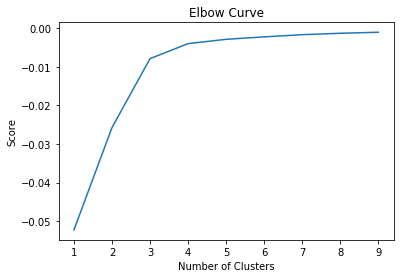

In [83]:
# Create Elbow curve to determine correct number of clusters
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = corKclust_df[['latitude']]
X_axis = corKclust_df[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [84]:
# Perform kmeans clustering on Cork Airbnb and add to datframe
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(corKclust_df[corKclust_df.columns[1:3]]) # Compute k-means clustering.
corKclust_df['cluster_label'] = kmeans.fit_predict(corKclust_df[corKclust_df.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(corKclust_df[corKclust_df.columns[1:3]]) # Labels of each point
corKclust_df.head(50)

id  latitude  longitude  cluster_label
0    9548704  51.89126   -8.46324              0
1   13344373  51.88995   -8.47027              0
2   27196730  51.89633   -8.48618              0
3    3088179  51.89269   -8.47284              0
4   24804603  51.88932   -8.46825              0
5   38741027  51.89623   -8.47748              0
6   15388361  51.88914   -8.50054              0
7   36666968  51.86630   -8.46725              0
8   17311815  51.89624   -8.46968              0
9   19499792  51.89426   -8.49226              0
10   3074863  51.89348   -8.47924              0
11  37032716  51.90095   -8.47636              0
12  13825973  51.86357   -8.44881              2
13  25348483  51.89049   -8.47042              0
14  26359097  51.89205   -8.47063              0
15  27382729  51.89202   -8.48265              0
16   2216069  51.87127   -8.45269              2
17  17354127  51.86813   -8.47917              0
18  17180728  51.89779   -8.48029              0
19  17236598  51.89718   -8.48200              0
20  33222836  51.89945   -8.47722              0
21  33775801  51.89143   -8.48332              0
22  34377208  51.89354   -8.47599              0
23  17214394  51.89632   -8.48329              0
24  23799104  51.89775   -8.47203              0
25  25278030  51.89723   -8.47845              0
26  31551232  51.86303   -8.44906              2
27  21922497  51.86572   -8.45076              2
28  19118811  51.86951   -8.44887              2
29  35089236  51.90332   -8.47117              0
30  33011926  51.90028   -8.46461              0
31  24280674  51.95008   -8.39776              2
32  32718143  51.90290   -8.46529              0
33  32380273  51.90207   -8.46415              0
34  35080220  51.90140   -8.46952              0
35  18058458  51.90469   -8.46023              0
36  25831254  51.90242   -8.46696              0
37  18805095  51.90530   -8.45914              0
38  35090988  51.90892   -8.47101              0
39  34377533  51.90565   -8.45174              0
40  18058734  51.90507   -8.45751              0
41  15077262  51.90407   -8.45269              0
42  29196565  51.93366   -8.39103              2
43  18649731  51.90464   -8.46915              0
44  35700639  51.90092   -8.46632              0
45  32631658  51.90194   -8.46336              0
46  23447934  51.91084   -8.43298              2
47  25271696  51.90078   -8.46927              0
48  30737220  51.90378   -8.45645              0
49  37032154  51.91310   -8.47583              0

In [85]:
# Visualize clusters on map of Cork
# create map

kclusters = 3

cormap_clusters = folium.Map(location=[corlatitude, corlongitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, id, cluster in zip(corKclust_df['latitude'], corKclust_df['longitude'], corKclust_df['id'], corKclust_df['cluster_label']):
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(cormap_clusters)
       
cormap_clusters

In [86]:
# Use geopy library to get geographical co-ordinates for Douglas, Cork
address = 'Douglas, Cork, Ireland'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
douglatitude = location.latitude
douglongitude = location.longitude
print('The geograpical coordinate of Douglas, Cork are {}, {}.'.format(douglatitude, douglongitude))

The geograpical coordinate of Douglas, Cork are 51.8774785, -8.436061.


In [87]:
# Use geopy library to get geographical co-ordinates for Blarney, Cork
address = 'Blarney, Cork, Ireland'

geolocator = Nominatim(user_agent="can_explorer")
location = geolocator.geocode(address)
blarlatitude = location.latitude
blarlongitude = location.longitude
print('The geograpical coordinate of Blarney, Cork are {}, {}.'.format(blarlatitude, blarlongitude))

The geograpical coordinate of Blarney, Cork are 51.9333535, -8.5666702.


## Use Foursquare API to explore venues in Cork City Centre, Douglas & Blarney

In [88]:
# Access Foursquare API

CLIENT_ID = 'JXVETAYDYL2KYQXYGROHGMZFPA0C1L34ORVUO2LVO3D2H0Y1' # your Foursquare ID
CLIENT_SECRET = 'U3TG2OKOUA5FXKXWUSRBWK022LG4CGUZRV4EZD0PSP2WASPS' # your Foursquare Secret

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
VERSION = '20200202'

Your credentials:
CLIENT_ID: JXVETAYDYL2KYQXYGROHGMZFPA0C1L34ORVUO2LVO3D2H0Y1
CLIENT_SECRET:U3TG2OKOUA5FXKXWUSRBWK022LG4CGUZRV4EZD0PSP2WASPS


In [89]:
# Create radius of 500m and limit of 50 venues
radius = 500
LIMIT = 50

In [90]:
# create the API request URL to serach for venues in Cork City Centre
url = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    corlatitude,
    corlongitude,
    radius,
    LIMIT)
corccresults = requests.get(url).json() 
corccresults

{'meta': {'code': 200, 'requestId': '5e3a7b6ce826ac001b984255'},
 'response': {'venues': [{'id': '4b76ca67f964a520555f2ee3',
    'name': 'Butlers Chocolate Café',
    'location': {'address': '30 Oliver Plunkett St',
     'lat': 51.89794991177399,
     'lng': -8.47071869776603,
     'labeledLatLngs': [{'label': 'display',
       'lat': 51.89794991177399,
       'lng': -8.47071869776603}],
     'distance': 9,
     'cc': 'IE',
     'city': 'Cork',
     'state': 'Co Cork',
     'country': 'Ireland',
     'formattedAddress': ['30 Oliver Plunkett St',
      'Cork',
      'Co Cork',
      'Ireland']},
    'categories': [{'id': '4bf58dd8d48988d1e0931735',
      'name': 'Coffee Shop',
      'pluralName': 'Coffee Shops',
      'shortName': 'Coffee Shop',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/coffeeshop_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1580891103',
    'hasPerk': False},
   {'id': '4c3dc1d015cb1b8d7b547cdc',
    'name': 'Ge

In [91]:
# assign relevant part of JSON to Cork City Centre venues
corccvenues = corccresults['response']['venues']

# tranform venues into a dataframe
corcc_df = json_normalize(corccvenues)
corcc_df.head(10)

categories  hasPerk  \
0  [{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...    False   
1  [{'id': '4bf58dd8d48988d172941735', 'name': 'P...    False   
2  [{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...    False   
3  [{'id': '4bf58dd8d48988d11b941735', 'name': 'P...    False   
4  [{'id': '4bf58dd8d48988d11b941735', 'name': 'P...    False   
5  [{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...    False   
6  [{'id': '52f2ab2ebcbc57f1066b8b31', 'name': 'C...    False   
7  [{'id': '4bf58dd8d48988d10c951735', 'name': 'C...    False   
8  [{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...    False   
9  [{'id': '4f04afc02fb6e1c99f3db0bc', 'name': 'M...    False   

                         id        location.address location.cc location.city  \
0  4b76ca67f964a520555f2ee3   30 Oliver Plunkett St          IE          Cork   
1  4c3dc1d015cb1b8d7b547cdc      Oliver Plunkett St          IE          Cork   
2  4c18f3e1fe5a76b0f5c90215             Winthrop St          IE          Cork   
3  4ba67a29f964a520745639e3         10 Winthrop St.          IE          Cork   
4  4c02b5ed9a7920a10fd9ce79  108 Oliver Plunkett St          IE          Cork   
5  4bdf57a46198c9b68ce016ff             Pembroke St          IE          Cork   
6  4c3dc1694bc9a5938d66d471       Oliver Plunket St          IE          Cork   
7  4f4500e2e4b0f94a3639f927                     NaN          IE           NaN   
8  4b3c8f13f964a5201c8525e3              South Mall          IE          Cork   
9  4bb468950cbcef3b00f2582a  109 Oliver Plunkett St          IE          Cork   

  location.country location.crossStreet  location.distance  \
0          Ireland                  NaN                  9   
1          Ireland                  NaN                 13   
2          Ireland                  NaN                 16   
3          Ireland                  NaN                 28   
4          Ireland                  NaN                 10   
5          Ireland                  NaN                 24   
6          Ireland                  NaN                 14   
7          Ireland                  NaN                 72   
8          Ireland                  NaN                102   
9          Ireland                  NaN                 13   

                          location.formattedAddress  \
0   [30 Oliver Plunkett St, Cork, Co Cork, Ireland]   
1      [Oliver Plunkett St, Cork, Co Cork, Ireland]   
2             [Winthrop St, Cork, Co Cork, Ireland]   
3         [10 Winthrop St., Cork, Co Cork, Ireland]   
4  [108 Oliver Plunkett St, Cork, Co Cork, Ireland]   
5             [Pembroke St, Cork, Co Cork, Ireland]   
6       [Oliver Plunket St, Cork, Co Cork, Ireland]   
7                                         [Ireland]   
8              [South Mall, Cork, Co Cork, Ireland]   
9  [109 Oliver Plunkett St, Cork, Co Cork, Ireland]   

                             location.labeledLatLngs  location.lat  \
0  [{'label': 'display', 'lat': 51.89794991177399...     51.897950   
1  [{'label': 'display', 'lat': 51.89799719284036...     51.897997   
2  [{'label': 'display', 'lat': 51.89807847807349...     51.898078   
3  [{'label': 'display', 'lat': 51.89816962412247...     51.898170   
4  [{'label': 'display', 'lat': 51.8980037711242,...     51.898004   
5  [{'label': 'display', 'lat': 51.89789665636476...     51.897897   
6  [{'label': 'display', 'lat': 51.89805379322438...     51.898054   
7  [{'label': 'display', 'lat': 51.89796169582751...     51.897962   
8  [{'label': 'display', 'lat': 51.89708416132273...     51.897084   
9  [{'label': 'display', 'lat': 51.8980290557128,...     51.898029   

   location.lng location.neighborhood location.postalCode location.state  \
0     -8.470719                   NaN                 NaN        Co Cork   
1     -8.470414                   NaN                 NaN        Co Cork   
2     -8.470602                   NaN                 NaN        Co Cork   
3     -8.470457                   NaN                 NaN        Co Co

In [92]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in corcc_df.columns if col.startswith('location.')] + ['id']
corcc_df_filtered = corcc_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
corcc_df_filtered['categories'] = corcc_df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
corcc_df_filtered.columns = [column.split('.')[-1] for column in corcc_df_filtered.columns]

corcc_df_filtered.head(10)

name         categories                 address  cc  \
0     Butlers Chocolate Café        Coffee Shop   30 Oliver Plunkett St  IE   
1  General Post Office (GPO)        Post Office      Oliver Plunkett St  IE   
2      O'Briens Sandwich Bar     Sandwich Place             Winthrop St  IE   
3            The Long Valley                Pub         10 Winthrop St.  IE   
4       Hibernian Bar (Hi B)                Pub  108 Oliver Plunkett St  IE   
5                  Fast Al's        Pizza Place             Pembroke St  IE   
6                   Leonidas     Chocolate Shop       Oliver Plunket St  IE   
7     Hennessys Hair Suppies     Cosmetics Shop                     NaN  IE   
8             Imperial Hotel              Hotel              South Mall  IE   
9                   Vodafone  Mobile Phone Shop  109 Oliver Plunkett St  IE   

   city  country crossStreet  distance  \
0  Cork  Ireland         NaN         9   
1  Cork  Ireland         NaN        13   
2  Cork  Ireland         NaN        16   
3  Cork  Ireland         NaN        28   
4  Cork  Ireland         NaN        10   
5  Cork  Ireland         NaN        24   
6  Cork  Ireland         NaN        14   
7   NaN  Ireland         NaN        72   
8  Cork  Ireland         NaN       102   
9  Cork  Ireland         NaN        13   

                                   formattedAddress  \
0   [30 Oliver Plunkett St, Cork, Co Cork, Ireland]   
1      [Oliver Plunkett St, Cork, Co Cork, Ireland]   
2             [Winthrop St, Cork, Co Cork, Ireland]   
3         [10 Winthrop St., Cork, Co Cork, Ireland]   
4  [108 Oliver Plunkett St, Cork, Co Cork, Ireland]   
5             [Pembroke St, Cork, Co Cork, Ireland]   
6       [Oliver Plunket St, Cork, Co Cork, Ireland]   
7                                         [Ireland]   
8              [South Mall, Cork, Co Cork, Ireland]   
9  [109 Oliver Plunkett St, Cork, Co Cork, Ireland]   

                                      labeledLatLngs        lat       lng  \
0  [{'label': 'display', 'lat': 51.89794991177399...  51.897950 -8.470719   
1  [{'label': 'display', 'lat': 51.89799719284036...  51.897997 -8.470414   
2  [{'label': 'display', 'lat': 51.89807847807349...  51.898078 -8.470602   
3  [{'label': 'display', 'lat': 51.89816962412247...  51.898170 -8.470457   
4  [{'label': 'display', 'lat': 51.8980037711242,...  51.898004 -8.470491   
5  [{'label': 'display', 'lat': 51.89789665636476...  51.897897 -8.470222   
6  [{'label': 'display', 'lat': 51.89805379322438...  51.898054 -8.470607   
7  [{'label': 'display', 'lat': 51.89796169582751...  51.897962 -8.471635   
8  [{'label': 'display', 'lat': 51.89708416132273...  51.897084 -8.469992   
9  [{'label': 'display', 'lat': 51.8980290557128,...  51.898029 -8.470478   

  neighborhood postalCode    state                        id  
0          NaN        NaN  Co Cork  4b76ca67f964a520555f2ee3  
1          NaN        NaN  Co Cork  4c3dc1d015cb1b8d7b547cdc  
2          NaN        NaN  Co Cork  4c18f3e1fe5a76b0f5c90215  
3          NaN        NaN  Co Cork  4ba67a29f964a520745639e3  
4          NaN        NaN  Co Cork  4c02b5ed9a7920a10fd9ce79  
5          NaN        NaN  Co Cork  4bdf57a46198c9b68ce016ff  
6          NaN        NaN  Co Cork  4c3dc1694bc9a5938d66d471  
7          NaN        NaN      NaN  4f4500e2e4b0f94a3639f927  
8          NaN        NaN  Co Cork  4b3c8f13f964a5201c8525e3  
9          NaN        NaN  Co Cork  4bb468950cbcef3b00f2582a

In [93]:
# Remove unnecessary columns to generate final Cork city centre venues listings dataframe
corccFinal_df = corcc_df_filtered.drop(['cc', 'city', 'country', 'crossStreet', 'formattedAddress', 'labeledLatLngs', 
                             'neighborhood', 'postalCode', 'state'], axis=1).reset_index(drop=True)
corccFinal_df

name                categories  \
0                Butlers Chocolate Café               Coffee Shop   
1             General Post Office (GPO)               Post Office   
2                 O'Briens Sandwich Bar            Sandwich Place   
3                       The Long Valley                       Pub   
4                  Hibernian Bar (Hi B)                       Pub   
5                             Fast Al's               Pizza Place   
6                              Leonidas            Chocolate Shop   
7                Hennessys Hair Suppies            Cosmetics Shop   
8                        Imperial Hotel                     Hotel   
9                              Vodafone         Mobile Phone Shop   
10                           McDonald's      Fast Food Restaurant   
11                  The Oliver Plunkett                       Pub   
12                               Boojum             Burrito Place   
13                       The Crane Lane                       Bar   
14                              Old Oak                       Bar   
15             The Cobbler Leather Shop        Miscellaneous Shop   
16                              Penneys            Clothing Store   
17                   ORSO Kitchen & Bar  Mediterranean Restaurant   
18              Seventy Six on The Mall                 Hotel Bar   
19                                Cocoa                      Café   
20             Club Vitae Gym Cork City      Gym / Fitness Center   
21                             Café Eco                      Café   
22                     Minihans Chemist                      None   
23                          Post Office                      None   
24                         Brown Thomas          Department Store   
25                       Enable Ireland    Thrift / Vintage Store   
26                              Pandora             Jewelry Store   
27                     Les Gourmandises         French Restaurant   
28             Frisky Irish Whiskey Bar                Whisky Bar   
29                        Cyprus Avenue              Concert Hall   
30                           Caffè Nero               Coffee Shop   
31                              Canty's                       Bar   
32  Arthur Mayne Pharmacy & Wine Garden                  Wine Bar   
33          O'Flynns Gourmet Sausage Co             Hot Dog Joint   
34                              Scoozi!                Restaurant   
35                  Cunneen Lock & Safe            Hardware Store   
36                        Mahers Coffee        Miscellaneous Shop   
37                            The Shack                Donut Shop   
38                             Guiney's          Department Store   
39                               Subway            Sandwich Place   
40                       The Framemaker                Art Studio   
41                        Bombay Palace         Indian Restaurant   
42                          Sugar Dolls                Nail Salon   
43           Mr Simms Olde Sweet Shoppe               Candy Store   
44                           Pro Musica               Record Shop   
45                            Nespresso         Food & Drink Shop   
46                        Fran and Jane                  Boutique   
47                  Barry's Photography           Photography Lab   
48                          Carl Scarpa                Shoe Store   
49                            Ielectron         Electronics Store   

                         address  distance        lat       lng  \
0          30 Oliver Plunkett St         9  51.897950 -8.470719   
1             Oliver Plunkett St        13  51.897997 -8.470414   
2                    Winthrop St        16  51.898078 -8.470602   
3                10 Winthrop St.        28  51.898170 -8.470457   
4         108 Oliver Plunkett St        10  51.898004 -8.470491   
5                    Pembroke St        24  51.897897 -8.470222   
6              Oliver Plunket St        14  51

Text(0, 0.5, 'Number of Venues')

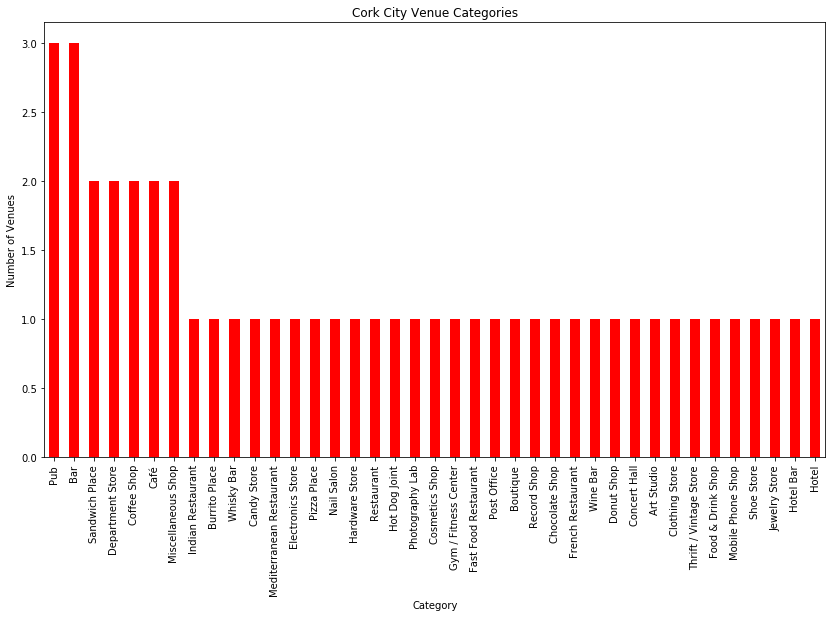

In [94]:
# Generate bar chart to show categories of venues in Cork City Centre
corccHist_df = corccFinal_df['categories'].value_counts().plot(kind='bar', color = 'r',
                                    figsize=(14,8),
                                    title="Cork City Venue Categories")
corccHist_df.set_xlabel("Category")
corccHist_df.set_ylabel("Number of Venues")

In [95]:
# create the API request URL to serach for venues in Douglas
url = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    douglatitude,
    douglongitude,
    radius,
    LIMIT)
dougresults = requests.get(url).json() 
dougresults

{'meta': {'code': 200, 'requestId': '5e3a7b9f9388d7001b97016e'},
 'response': {'venues': [{'id': '4b5b421ff964a52010ef28e3',
    'name': 'KC & Son & Sons',
    'location': {'address': 'Douglas Village',
     'lat': 51.877630872860195,
     'lng': -8.436373185378578,
     'labeledLatLngs': [{'label': 'display',
       'lat': 51.877630872860195,
       'lng': -8.436373185378578}],
     'distance': 27,
     'cc': 'IE',
     'city': 'Cork',
     'state': 'Co Cork',
     'country': 'Ireland',
     'formattedAddress': ['Douglas Village', 'Cork', 'Co Cork', 'Ireland']},
    'categories': [{'id': '4bf58dd8d48988d16c941735',
      'name': 'Burger Joint',
      'pluralName': 'Burger Joints',
      'shortName': 'Burgers',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/burger_',
       'suffix': '.png'},
      'primary': True}],
    'venuePage': {'id': '87801881'},
    'referralId': 'v-1580891110',
    'hasPerk': False},
   {'id': '52f6549b498e22bc130bd821',
    'name': 'Sub

In [96]:
# assign relevant part of JSON to Douglas venues
dougvenues = dougresults['response']['venues']

# tranform venues into a dataframe
doug_df = json_normalize(dougvenues)
doug_df.head(10)

categories  hasPerk  \
0  [{'id': '4bf58dd8d48988d16c941735', 'name': 'B...    False   
1  [{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...    False   
2  [{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...    False   
3  [{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...    False   
4  [{'id': '4bf58dd8d48988d116941735', 'name': 'B...    False   
5  [{'id': '4bf58dd8d48988d1fd941735', 'name': 'S...    False   
6  [{'id': '4bf58dd8d48988d116941735', 'name': 'B...    False   
7  [{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...    False   
8  [{'id': '4bf58dd8d48988d145941735', 'name': 'C...    False   
9  [{'id': '4bf58dd8d48988d16e941735', 'name': 'F...    False   

                         id        location.address location.cc location.city  \
0  4b5b421ff964a52010ef28e3         Douglas Village          IE          Cork   
1  52f6549b498e22bc130bd821      Church Rd, Douglas          IE          Cork   
2  5e110d8a2810f5000807f957  3 Main Street, Douglas          IE          Cork   
3  54b18884498e9899feebdf8a                     NaN          IE           NaN   
4  4b8981acf964a520083d32e3                     NaN          IE           NaN   
5  4cf7a7ddc28df04d0366d115                 Douglas          IE          Cork   
6  4b5709b3f964a520e42328e3            Douglas East          IE          Cork   
7  4b93a33ff964a520294b34e3       7 Douglas Village          IE          Cork   
8  5030f020e4b04de6f45235d9                     NaN          IE           NaN   
9  4b7e9bf3f964a5203af52fe3   East Village, Douglas          IE          Cork   

  location.country location.crossStreet  location.distance  \
0          Ireland                  NaN                 27   
1          Ireland                  NaN                 13   
2          Ireland                  NaN                  9   
3          Ireland                  NaN                 40   
4          Ireland                  NaN                155   
5          Ireland                  NaN                148   
6          Ireland                  NaN                 36   
7          Ireland                  NaN                 31   
8          Ireland                  NaN                 22   
9          Ireland                  NaN                193   

                          location.formattedAddress  \
0         [Douglas Village, Cork, Co Cork, Ireland]   
1      [Church Rd, Douglas, Cork, Co Cork, Ireland]   
2  [3 Main Street, Douglas, Cork, Co Cork, Ireland]   
3                                         [Ireland]   
4                                         [Ireland]   
5                 [Douglas, Cork, Co Cork, Ireland]   
6            [Douglas East, Cork, Co Cork, Ireland]   
7       [7 Douglas Village, Cork, Co Cork, Ireland]   
8                                         [Ireland]   
9   [East Village, Douglas, Cork, Co Cork, Ireland]   

                             location.labeledLatLngs  location.lat  \
0  [{'label': 'display', 'lat': 51.87763087286019...     51.877631   
1  [{'label': 'display', 'lat': 51.877363, 'lng':...     51.877363   
2  [{'label': 'display', 'lat': 51.87741320452142...     51.877413   
3  [{'label': 'display', 'lat': 51.87721838508732...     51.877218   
4  [{'label': 'display', 'lat': 51.87661353096141...     51.876614   
5  [{'label': 'display', 'lat': 51.87752676229338...     51.877527   
6  [{'label': 'display', 'lat': 51.87715239080867...     51.877152   
7  [{'label': 'display', 'lat': 51.877201, 'lng':...     51.877201   
8  [{'label': 'display', 'lat': 51.87737325766458...     51.877373   
9  [{'label': 'display', 'lat': 51.87795720116578...     51.877957   

   location.lng location.neighborhood location.postalCode location.state  \
0     -8.436373                   NaN                 NaN        Co Cork   
1     -8.436019                   NaN                 NaN        Co Cork   
2     -8.435980                   NaN                 NaN        Co Cork   
3     -8.436470                   NaN                 NaN            N

In [97]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in doug_df.columns if col.startswith('location.')] + ['id']
doug_df_filtered = doug_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
doug_df_filtered['categories'] = doug_df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
doug_df_filtered.columns = [column.split('.')[-1] for column in doug_df_filtered.columns]

doug_df_filtered.head(10)

name            categories  \
0                  KC & Son & Sons          Burger Joint   
1                           Subway        Sandwich Place   
2                           Subway        Sandwich Place   
3                         Palmento           Pizza Place   
4                  o driscolls bar                   Bar   
5  Douglas Village Shopping Centre         Shopping Mall   
6                Barrys of Douglas                   Bar   
7                Bullys Restaurant            Restaurant   
8   Rose Garden Chinese Restaurant    Chinese Restaurant   
9                       McDonald's  Fast Food Restaurant   

                  address  cc  city  country crossStreet  distance  \
0         Douglas Village  IE  Cork  Ireland         NaN        27   
1      Church Rd, Douglas  IE  Cork  Ireland         NaN        13   
2  3 Main Street, Douglas  IE  Cork  Ireland         NaN         9   
3                     NaN  IE   NaN  Ireland         NaN        40   
4                     NaN  IE   NaN  Ireland         NaN       155   
5                 Douglas  IE  Cork  Ireland         NaN       148   
6            Douglas East  IE  Cork  Ireland         NaN        36   
7       7 Douglas Village  IE  Cork  Ireland         NaN        31   
8                     NaN  IE   NaN  Ireland         NaN        22   
9   East Village, Douglas  IE  Cork  Ireland         NaN       193   

                                   formattedAddress  \
0         [Douglas Village, Cork, Co Cork, Ireland]   
1      [Church Rd, Douglas, Cork, Co Cork, Ireland]   
2  [3 Main Street, Douglas, Cork, Co Cork, Ireland]   
3                                         [Ireland]   
4                                         [Ireland]   
5                 [Douglas, Cork, Co Cork, Ireland]   
6            [Douglas East, Cork, Co Cork, Ireland]   
7       [7 Douglas Village, Cork, Co Cork, Ireland]   
8                                         [Ireland]   
9   [East Village, Douglas, Cork, Co Cork, Ireland]   

                                      labeledLatLngs        lat       lng  \
0  [{'label': 'display', 'lat': 51.87763087286019...  51.877631 -8.436373   
1  [{'label': 'display', 'lat': 51.877363, 'lng':...  51.877363 -8.436019   
2  [{'label': 'display', 'lat': 51.87741320452142...  51.877413 -8.435980   
3  [{'label': 'display', 'lat': 51.87721838508732...  51.877218 -8.436470   
4  [{'label': 'display', 'lat': 51.87661353096141...  51.876614 -8.437841   
5  [{'label': 'display', 'lat': 51.87752676229338...  51.877527 -8.438221   
6  [{'label': 'display', 'lat': 51.87715239080867...  51.877152 -8.436135   
7  [{'label': 'display', 'lat': 51.877201, 'lng':...  51.877201 -8.436005   
8  [{'label': 'display', 'lat': 51.87737325766458...  51.877373 -8.436347   
9  [{'label': 'display', 'lat': 51.87795720116578...  51.877957 -8.433349   

  neighborhood postalCode    state                        id  
0          NaN        NaN  Co Cork  4b5b421ff964a52010ef28e3  
1          NaN        NaN  Co Cork  52f6549b498e22bc130bd821  
2          NaN        NaN  Co Cork  5e110d8a2810f5000807f957  
3          NaN        NaN      NaN  54b18884498e9899feebdf8a  
4          NaN        NaN      NaN  4b8981acf964a520083d32e3  
5          NaN        NaN  Co Cork  4cf7a7ddc28df04d0366d115  
6          NaN        NaN  Co Cork  4b5709b3f964a520e42328e3  
7          NaN        NaN  Co Cork  4b93a33ff964a520294b34e3  
8          NaN        NaN      NaN  5030f020e4b04de6f45235d9  
9          NaN        NaN  Co Cork  4b7e9bf3f964a5203af52fe3

In [98]:
# Remove unnecessary columns to generate final douglas venueslistings dataframe
dougFinal_df = doug_df_filtered.drop(['cc', 'city', 'country', 'crossStreet', 'formattedAddress', 'labeledLatLngs', 
                             'neighborhood', 'postalCode', 'state'], axis=1).reset_index(drop=True)
dougFinal_df

name              categories  \
0                             KC & Son & Sons            Burger Joint   
1                                      Subway          Sandwich Place   
2                                      Subway          Sandwich Place   
3                                    Palmento             Pizza Place   
4                             o driscolls bar                     Bar   
5             Douglas Village Shopping Centre           Shopping Mall   
6                           Barrys of Douglas                     Bar   
7                           Bullys Restaurant              Restaurant   
8              Rose Garden Chinese Restaurant      Chinese Restaurant   
9                                  McDonald's    Fast Food Restaurant   
10                                      Topaz             Gas Station   
11                               Costa Coffee             Coffee Shop   
12                                  Starbucks             Coffee Shop   
13                            Marks & Spencer           Grocery Store   
14                                Tesco Extra             Supermarket   
15                          Marks and Spencer           Deli / Bodega   
16                   Neasa Long Physiotherapy      Physical Therapist   
17                                      Ramen        Asian Restaurant   
18                                MacCarthy’s  Furniture / Home Store   
19                   Four Star Pizza, Douglas             Pizza Place   
20                     Douglas Farmers Market          Farmers Market   
21                                  Lal Quila       Indian Restaurant   
22               Dennehy's Health and Fitness                     Gym   
23                     Douglas Community Park                    Park   
24                                    Tk Maxx          Clothing Store   
25                                   M&S Cafe                    Café   
26                                    El Vino        Tapas Restaurant   
27                             Douglas Cinena                    None   
28                                  12 Tables                  Bistro   
29                                 Marcello's      Italian Restaurant   
30                                      Eco's              Restaurant   
31                                   I Scream          Ice Cream Shop   
32                               East Village              Restaurant   
33                                        KFC    Fast Food Restaurant   
34                                Cinemaworld               Multiplex   
35                       Animal Care Hospital            Veterinarian   
36              Bamboo House Chinese Takeaway                    None   
37                    La Calavera Burrito Bar           Burrito Place   
38                           The South County                     Pub   
39                                     Haveli       Indian Restaurant   
40                            Golden Elephant         Thai Restaurant   
41  Total Health Chiropractic Wellness Clinic            Chiropractor   
42                                     Dino's       Fish & Chips Shop   
43                                Fudi & More      Chinese Restaurant   
44                      BB's Coffee & Muffins             Coffee Shop   
45                             Domino's Pizza             Pizza Place   
46              O'Sullivan's Bar & Restaurant                     Bar   
47                                  Quigley's             Coffee Shop   
48                           St Luke's Church                  Church   
49                  Indoor Playground Douglas              Playground   

                                              address  distance        lat  \
0                                     Douglas Village        27  51.877631   
1                                  Church Rd, Douglas        13  51.877363   
2                              3 Main Street, Douglas         9  51.877413   
3    

Text(0, 0.5, 'Number of Venues')

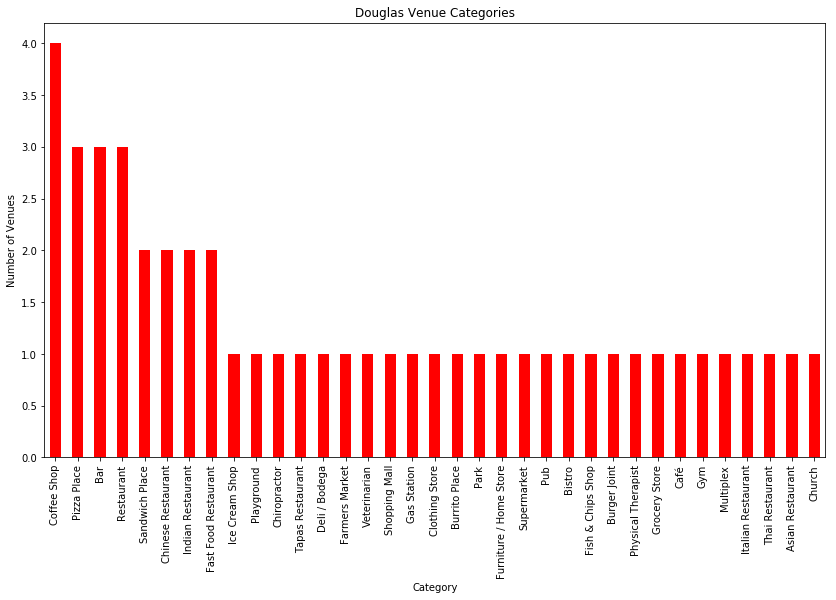

In [99]:
# Generate bar chart to show categories of venues in Douglas
dougHist_df = dougFinal_df['categories'].value_counts().plot(kind='bar', color = 'r',
                                    figsize=(14,8),
                                    title="Douglas Venue Categories")
dougHist_df.set_xlabel("Category")
dougHist_df.set_ylabel("Number of Venues")

In [100]:
# create the API request URL to serach for venues in Blarney
url = "https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
    CLIENT_ID,
    CLIENT_SECRET,
    VERSION,
    blarlatitude,
    blarlongitude,
    radius,
    LIMIT)
blarresults = requests.get(url).json() 
blarresults

{'meta': {'code': 200, 'requestId': '5e3a7a8b02a17200214b4fed'},
 'response': {'venues': [{'id': '4bbef73182a2ef3b9d0d2cd2',
    'name': 'Blarney Castle',
    'location': {'address': 'Caisleán na Blarnan',
     'lat': 51.931414556882935,
     'lng': -8.568517585656696,
     'labeledLatLngs': [{'label': 'display',
       'lat': 51.931414556882935,
       'lng': -8.568517585656696}],
     'distance': 250,
     'cc': 'IE',
     'city': 'Blarney',
     'state': 'Co Cork',
     'country': 'Ireland',
     'formattedAddress': ['Caisleán na Blarnan',
      'Blarney',
      'Co Cork',
      'Ireland']},
    'categories': [{'id': '50aaa49e4b90af0d42d5de11',
      'name': 'Castle',
      'pluralName': 'Castles',
      'shortName': 'Castle',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/beach_',
       'suffix': '.png'},
      'primary': True}],
    'referralId': 'v-1580891117',
    'hasPerk': False},
   {'id': '4c94c11572dd224b26aa9c91',
    'name': "Christy's",


In [101]:
# assign relevant part of JSON to Blarney venues
blarvenues = blarresults['response']['venues']

# tranform venues into a dataframe
blar_df = json_normalize(blarvenues)
blar_df.head()

categories  hasPerk  \
0  [{'id': '50aaa49e4b90af0d42d5de11', 'name': 'C...    False   
1  [{'id': '4bf58dd8d48988d116941735', 'name': 'B...    False   
2  [{'id': '4bf58dd8d48988d103951735', 'name': 'C...    False   
3  [{'id': '4bf58dd8d48988d11b941735', 'name': 'P...    False   
4  [{'id': '4bf58dd8d48988d132941735', 'name': 'C...    False   

                         id             location.address location.cc  \
0  4bbef73182a2ef3b9d0d2cd2          Caisleán na Blarnan          IE   
1  4c94c11572dd224b26aa9c91  Blarney Woollen Mills Hotel          IE   
2  4b5c7aa1f964a520d83129e3               Millstream Row          IE   
3  4be14096a7380f479a8d19b0                   The Square          IE   
4  4f2d7084e4b0dbffdc3c0f7e                      Blarney          IE   

  location.city location.country location.crossStreet  location.distance  \
0       Blarney          Ireland                  NaN                250   
1       Co Cork          Ireland                  NaN                 54   
2       Blarney          Ireland                  NaN                 71   
3       Blarney          Ireland                  NaN                 74   
4           NaN          Ireland                  NaN               2226   

                           location.formattedAddress  \
0   [Caisleán na Blarnan, Blarney, Co Cork, Ireland]   
1  [Blarney Woollen Mills Hotel, Co Cork, Co Cork...   
2        [Millstream Row, Blarney, Co Cork, Ireland]   
3            [The Square, Blarney, Co Cork, Ireland]   
4                                 [Blarney, Ireland]   

                             location.labeledLatLngs  location.lat  \
0  [{'label': 'display', 'lat': 51.93141455688293...     51.931415   
1  [{'label': 'display', 'lat': 51.93318421852336...     51.933184   
2  [{'label': 'display', 'lat': 51.93313482234061...     51.933135   
3  [{'label': 'display', 'lat': 51.93312512346203...     51.933125   
4  [{'label': 'display', 'lat': 51.94853, 'lng': ...     51.948530   

   location.lng location.state  \
0     -8.568518        Co Cork   
1     -8.565923        Co Cork   
2     -8.565694        Co Cork   
3     -8.567697        Co Cork   
4     -8.545540            NaN   

                                                name    referralId  \
0                                     Blarney Castle  v-1580891117   
1                                          Christy's  v-1580891117   
2                              Blarney Woollen Mills  v-1580891117   
3                                      Muskerry Arms  v-1580891117   
4  Catholic Church of the Immaculate Conception (...  v-1580891117   

  venuePage.id  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN

In [102]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in blar_df.columns if col.startswith('location.')] + ['id']
blar_df_filtered = blar_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
blar_df_filtered['categories'] = blar_df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
blar_df_filtered.columns = [column.split('.')[-1] for column in blar_df_filtered.columns]

blar_df_filtered.head(10)

name        categories  \
0                                     Blarney Castle            Castle   
1                                          Christy's               Bar   
2                              Blarney Woollen Mills    Clothing Store   
3                                      Muskerry Arms               Pub   
4  Catholic Church of the Immaculate Conception (...            Church   
5                               Blarney Castle Hotel             Hotel   
6                                            Dentist  Dentist's Office   
7                                             Centra     Grocery Store   
8                                The Mill Restaurant        Restaurant   
9                                        Meadow Bank   Bed & Breakfast   

                       address  cc     city  country      crossStreet  \
0          Caisleán na Blarnan  IE  Blarney  Ireland              NaN   
1  Blarney Woollen Mills Hotel  IE  Co Cork  Ireland              NaN   
2               Millstream Row  IE  Blarney  Ireland              NaN   
3                   The Square  IE  Blarney  Ireland              NaN   
4                      Blarney  IE      NaN  Ireland              NaN   
5  The Square, Blarney Village  IE  Co Cork  Ireland  Blarney Village   
6                      blarney  IE      NaN  Ireland              NaN   
7                          NaN  IE  Blarney  Ireland              NaN   
8  Blarney Woollen Mills Hotel  IE  Blarney  Ireland              NaN   
9                          NaN  IE  Blarney  Ireland              NaN   

   distance                                   formattedAddress  \
0       250   [Caisleán na Blarnan, Blarney, Co Cork, Ireland]   
1        54  [Blarney Woollen Mills Hotel, Co Cork, Co Cork...   
2        71        [Millstream Row, Blarney, Co Cork, Ireland]   
3        74            [The Square, Blarney, Co Cork, Ireland]   
4      2226                                 [Blarney, Ireland]   
5       109  [The Square, Blarney Village (Blarney Village)...   
6       151                                 [blarney, Ireland]   
7        94                        [Blarney, Co Cork, Ireland]   
8        96  [Blarney Woollen Mills Hotel, Blarney, Co Cork...   
9       139                        [Blarney, Co Cork, Ireland]   

                                      labeledLatLngs        lat       lng  \
0  [{'label': 'display', 'lat': 51.93141455688293...  51.931415 -8.568518   
1  [{'label': 'display', 'lat': 51.93318421852336...  51.933184 -8.565923   
2  [{'label': 'display', 'lat': 51.93313482234061...  51.933135 -8.565694   
3  [{'label': 'display', 'lat': 51.93312512346203...  51.933125 -8.567697   
4  [{'label': 'display', 'lat': 51.94853, 'lng': ...  51.948530 -8.545540   
5  [{'label': 'display', 'lat': 51.93242918656407...  51.932429 -8.567205   
6  [{'label': 'display', 'lat': 51.9328548386693,...  51.932855 -8.568727   
7  [{'label': 'display', 'lat': 51.933083, 'lng':...  51.933083 -8.567974   
8  [{'label': 'display', 'lat': 51.93311595520374...  51.933116 -8.565317   
9  [{'label': 'display', 'lat': 51.93309105262502...  51.933091 -8.564690   

     state                        id  
0  Co Cork  4bbef73182a2ef3b9d0d2cd2  
1  Co Cork  4c94c11572dd224b26aa9c91  
2  Co Cork  4b5c7aa1f964a520d83129e3  
3  Co Cork  4be14096a7380f479a8d19b0  
4      NaN  4f2d7084e4b0dbffdc3c0f7e  
5  Co Cork  4cd5823f886cb60c0e5e8489  
6      NaN  51fb6880498ec0752d4dfc71  
7  Co Cork  5b01884c295513002c37f376  
8  Co Cork  4f6b2effe4b0f7fc5483a17b  
9  Co Cork  4c5d9386857ca593e833cdcb

In [103]:
# Remove unnecessary columns to generate final Blarney venues listings dataframe
blarFinal_df = blar_df_filtered.drop(['cc', 'city', 'country', 'crossStreet', 'formattedAddress', 'labeledLatLngs', 'state'], axis=1).reset_index(drop=True)
blarFinal_df

name  \
0                                      Blarney Castle   
1                                           Christy's   
2                               Blarney Woollen Mills   
3                                       Muskerry Arms   
4   Catholic Church of the Immaculate Conception (...   
5                                Blarney Castle Hotel   
6                                             Dentist   
7                                              Centra   
8                                 The Mill Restaurant   
9                                         Meadow Bank   
10                        Blarney Woollen Mills Hotel   
11                                     Blarney Square   
12                                    Bus 215 To Cork   
13                           Muskerry Arms Guesthouse   
14                          Blarney Chocolate Factory   
15                                           Claddagh   
16                                  The Blarney Stone   
17                         Lantern Chinese Restaurant   
18                                          Suko Thai   
19                                Blarney Post Office   
20                   Johnny's At Blarney Castle Hotel   
21                        The Old Blarney Post Office   
22                      Scoil Mhuire Gan Smal Blarney   
23                                           EATin'IT   
24                                     Doctor Surgery   
25                                  Collins SuperValu   
26                                 Blarney NCT Centre   
27                                               Erin   
28                                The White House B&B   
29                                         Rock Close   
30                                     Blake's Centra   
31                                      Poison Garden   
32                                      Blarney House   
33                                   Coach House Café   
34                         Hc21 Blarney Business Park   
35                                     The Blue Haven   
36                                          Tung Sing   
37                               Shournagh Child Care   
38                        Gleann Fia, By Clancy Homes   
39                                           Pharmacy   
40                                   The Square Table   
41                                   Horses Graveyard   
42                                             Church   
43                                        Badger Cave   
44               Camp Junction House Bed & Breakfast.   
45                   Blarney Caravan and Camping Park   
46                                         The Groves   
47                                    CIT GAA Stadium   
48                                     Blarney United   
49                              woodlands, kerry pike   

                     categories                      address  distance  \
0                        Castle          Caisleán na Blarnan       250   
1                           Bar  Blarney Woollen Mills Hotel        54   
2                Clothing Store               Millstream Row        71   
3                           Pub                   The Square        74   
4                        Church                      Blarney      2226   
5                         Hotel  The Square, Blarney Village       109   
6              Dentist's Office                      blarney       151   
7                 Grocery Store                          NaN        94   
8                    Restaurant  Blarney Woollen Mills Hotel        96   
9               Bed & Breakfast                          NaN       139   
10                        Hotel                      Blarney       134   
11                         Park                          NaN       144   
12                     Bus Line                          NaN        48   
13              Bed & Breakfast                          NaN        52   
14               Ice Cream Shop

Text(0, 0.5, 'Number of Venues')

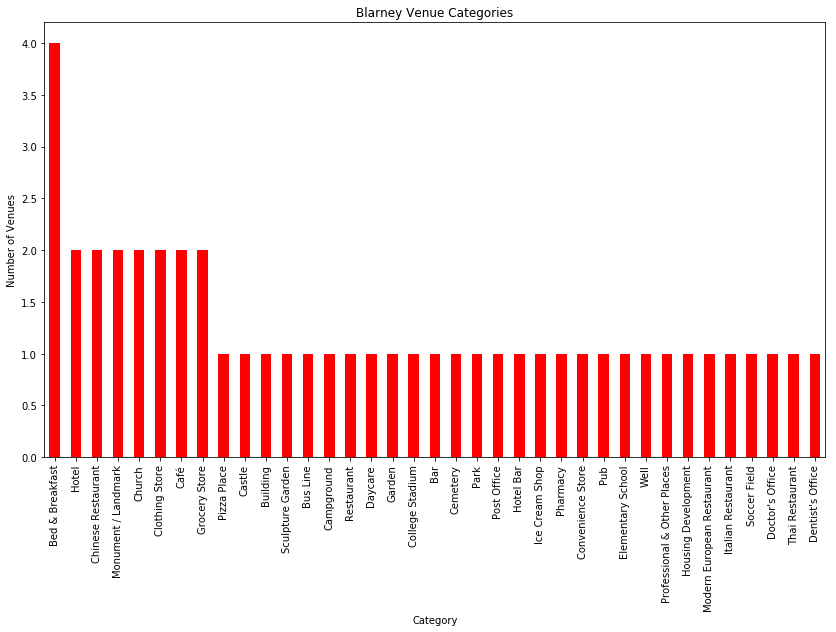

In [104]:
# Generate bar chart to show categories of venues in Blarney
blarHist_df = blarFinal_df['categories'].value_counts().plot(kind='bar', color = 'r',
                                    figsize=(14,8),
                                    title="Blarney Venue Categories")
blarHist_df.set_xlabel("Category")
blarHist_df.set_ylabel("Number of Venues")